1] PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix as cm, accuracy_score as ac, classification_report as report,\
roc_curve, roc_auc_score , recall_score , precision_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving forestfires.csv to forestfires (1).csv


In [ ]:
forest_fire = pd.read_csv('forestfires.csv')

In [ ]:
forest_fire 

month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  ...  monthfeb  \
0     mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0  ...         0   
1     oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0  ...         0   
2     oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0  ...         0   
3     mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2  ...         0   
4     mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0  ...         0   
..    ...  ...   ...    ...    ...   ...   ...  ..   ...   ...  ...       ...   
512   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0  ...         0   
513   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  ...         0   
514   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  ...         0   
515   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0  ...         0   
516   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0  ...         0   

     monthjan  monthjul  monthjun  monthmar  monthmay  monthnov  monthoct  \
0           0         0         0         1         0         0         0   
1           0         0         0         0         0         0         1   
2           0         0         0         0         0         0         1   
3           0         0         0         1         0         0         0   
4           0         0         0         1         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
512         0         0         0         0         0         0         0   
513         0         0         0         0         0         0         0   
514         0         0         0         0         0         0         0   
515         0         0         0         0         0         0         0   
516         0         0         0         0         0         1         0   

     monthsep  size_category  
0           0          small  
1           0          small  
2           0          small  
3           0          small  
4           0          small  
..        ...            ...  
512         0          large  
513         0          large  
514         0          large  
515         0          small  
516         0          small  

[517 rows x 31 columns]

Data Exploration

In [ ]:
# print shape of dataset with rows and columns
print(forest_fire.shape)
# print top 5 records
forest_fire.head()

(517, 31)


month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  ...  monthfeb  \
0   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0  ...         0   
1   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0  ...         0   
2   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0  ...         0   
3   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2  ...         0   
4   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0  ...         0   

   monthjan  monthjul  monthjun  monthmar  monthmay  monthnov  monthoct  \
0         0         0         0         1         0         0         0   
1         0         0         0         0         0         0         1   
2         0         0         0         0         0         0         1   
3         0         0         0         1         0         0         0   
4         0         0         0         1         0         0         0   

   monthsep  size_category  
0         0          small  
1         0          small  
2         0          small  
3         0          small  
4         0          small  

[5 rows x 31 columns]

Descriptive Statistics

In [ ]:
forest_fire.describe().T

count        mean         std   min    25%     50%     75%      max
FFMC      517.0   90.644681    5.520111  18.7   90.2   91.60   92.90    96.20
DMC       517.0  110.872340   64.046482   1.1   68.6  108.30  142.40   291.30
DC        517.0  547.940039  248.066192   7.9  437.7  664.20  713.90   860.60
ISI       517.0    9.021663    4.559477   0.0    6.5    8.40   10.80    56.10
temp      517.0   18.889168    5.806625   2.2   15.5   19.30   22.80    33.30
RH        517.0   44.288201   16.317469  15.0   33.0   42.00   53.00   100.00
wind      517.0    4.017602    1.791653   0.4    2.7    4.00    4.90     9.40
rain      517.0    0.021663    0.295959   0.0    0.0    0.00    0.00     6.40
area      517.0   12.847292   63.655818   0.0    0.0    0.52    6.57  1090.84
dayfri    517.0    0.164410    0.371006   0.0    0.0    0.00    0.00     1.00
daymon    517.0    0.143133    0.350548   0.0    0.0    0.00    0.00     1.00
daysat    517.0    0.162476    0.369244   0.0    0.0    0.00    0.00     1.00
daysun    517.0    0.183752    0.387657   0.0    0.0    0.00    0.00     1.00
daythu    517.0    0.117988    0.322907   0.0    0.0    0.00    0.00     1.00
daytue    517.0    0.123791    0.329662   0.0    0.0    0.00    0.00     1.00
daywed    517.0    0.104449    0.306138   0.0    0.0    0.00    0.00     1.00
monthapr  517.0    0.017408    0.130913   0.0    0.0    0.00    0.00     1.00
monthaug  517.0    0.355899    0.479249   0.0    0.0    0.00    1.00     1.00
monthdec  517.0    0.017408    0.130913   0.0    0.0    0.00    0.00     1.00
monthfeb  517.0    0.038685    0.193029   0.0    0.0    0.00    0.00     1.00
monthjan  517.0    0.003868    0.062137   0.0    0.0    0.00    0.00     1.00
monthjul  517.0    0.061896    0.241199   0.0    0.0    0.00    0.00     1.00
monthjun  517.0    0.032882    0.178500   0.0    0.0    0.00    0.00     1.00
monthmar  517.0    0.104449    0.306138   0.0    0.0    0.00    0.00     1.00
monthmay  517.0    0.003868    0.062137   0.0    0.0    0.00    0.00     1.00
monthnov  517.0    0.001934    0.043980   0.0    0.0    0.00    0.00     1.00
monthoct  517.0    0.029014    0.168007   0.0    0.0    0.00    0.00     1.00
monthsep  517.0    0.332689    0.471632   0.0    0.0    0.00    1.00     1.00

Missing Values

In [ ]:
forest_fire.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
dayfri           0
daymon           0
daysat           0
daysun           0
daythu           0
daytue           0
daywed           0
monthapr         0
monthaug         0
monthdec         0
monthfeb         0
monthjan         0
monthjul         0
monthjun         0
monthmar         0
monthmay         0
monthnov         0
monthoct         0
monthsep         0
size_category    0
dtype: int64

So we see that there are no missing values.

 Duplicated Values

In [ ]:
forest_fire[forest_fire.duplicated()]

month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  ...  monthfeb  \
53    aug  wed  92.1  111.2  654.1   9.6  20.4  42   4.9   0.0  ...         0   
100   aug  sun  91.4  142.4  601.4  10.6  19.8  39   5.4   0.0  ...         0   
215   mar  sat  91.7   35.8   80.8   7.8  17.0  27   4.9   0.0  ...         0   
303   jun  fri  91.1   94.1  232.1   7.1  19.2  38   4.5   0.0  ...         0   
426   aug  thu  91.6  248.4  753.8   6.3  20.4  56   2.2   0.0  ...         0   
461   aug  sat  93.7  231.1  715.1   8.4  18.9  64   4.9   0.0  ...         0   
501   aug  tue  96.1  181.1  671.2  14.3  21.6  65   4.9   0.8  ...         0   
508   aug  fri  91.0  166.9  752.6   7.1  25.9  41   3.6   0.0  ...         0   

     monthjan  monthjul  monthjun  monthmar  monthmay  monthnov  monthoct  \
53          0         0         0         0         0         0         0   
100         0         0         0         0         0         0         0   
215         0         0         0         1         0         0         0   
303         0         0         1         0         0         0         0   
426         0         0         0         0         0         0         0   
461         0         0         0         0         0         0         0   
501         0         0         0         0         0         0         0   
508         0         0         0         0         0         0         0   

     monthsep  size_category  
53          0          small  
100         0          small  
215         0          large  
303         0          small  
426         0          small  
461         0          small  
501         0          small  
508         0          small  

[8 rows x 31 columns]

In [ ]:
forest_fire[forest_fire.duplicated()].shape

(8, 31)

Numerical Variables

In [ ]:
# List of Numerical Variables
numerical_features=[feature for feature in forest_fire.columns if forest_fire[feature].dtypes != 'O']

print('Number of numerical variables:', len(numerical_features))

# Visualize the numerical variables
forest_fire[numerical_features].head()

Number of numerical variables: 28


FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  dayfri  ...  monthdec  \
0  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0       1  ...         0   
1  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0       0  ...         0   
2  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0       0  ...         0   
3  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0       1  ...         0   
4  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0       0  ...         0   

   monthfeb  monthjan  monthjul  monthjun  monthmar  monthmay  monthnov  \
0         0         0         0         0         1         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         1         0         0   
4         0         0         0         0         1         0         0   

   monthoct  monthsep  
0         0         0  
1         1         0  
2         1         0  
3         0         0  
4         0         0  

[5 rows x 28 columns]

Discrete Feature

In [ ]:
discrete_feature=[feature for feature in numerical_features if len(forest_fire[feature].unique())<25]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))

Discrete Variables Count: 21


Continuous Variable

In [ ]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 7


Categorical Variables

In [ ]:
# find categorical variables

categorical = [var for var in forest_fire.columns if forest_fire[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 3 categorical variables

The categorical variables are :

 ['month', 'day', 'size_category']


Frequency counts of categorical variables

In [ ]:
# view frequency counts of values in categorical variables

for var in categorical: 
    
    print(forest_fire[var].value_counts())

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64
small    378
large    139
Name: size_category, dtype: int64


In [ ]:
# view frequency distribution of categorical variables

for var in categorical: 
    
    print(forest_fire[var].value_counts()/np.float(len(forest_fire)))


aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: month, dtype: float64
sun    0.183752
fri    0.164410
sat    0.162476
mon    0.143133
tue    0.123791
thu    0.117988
wed    0.104449
Name: day, dtype: float64
small    0.731141
large    0.268859
Name: size_category, dtype: float64


Number of labels: cardinality

In [ ]:
# check for cardinality in categorical variables

for var in categorical:
    
    print(var, ' contains ', len(forest_fire[var].unique()), ' labels')

month  contains  12  labels
day  contains  7  labels
size_category  contains  2  labels


In [ ]:
forest_fire.corr()

FFMC       DMC        DC       ISI      temp        RH  \
FFMC      1.000000  0.382619  0.330512  0.531805  0.431532 -0.300995   
DMC       0.382619  1.000000  0.682192  0.305128  0.469594  0.073795   
DC        0.330512  0.682192  1.000000  0.229154  0.496208 -0.039192   
ISI       0.531805  0.305128  0.229154  1.000000  0.394287 -0.132517   
temp      0.431532  0.469594  0.496208  0.394287  1.000000 -0.527390   
RH       -0.300995  0.073795 -0.039192 -0.132517 -0.527390  1.000000   
wind     -0.028485 -0.105342 -0.203466  0.106826 -0.227116  0.069410   
rain      0.056702  0.074790  0.035861  0.067668  0.069491  0.099751   
area      0.040122  0.072994  0.049383  0.008258  0.097844 -0.075519   
dayfri    0.019306 -0.012010 -0.004220  0.046695 -0.071949  0.064506   
daymon   -0.059396 -0.107921 -0.052993 -0.158601 -0.136529  0.009376   
daysat   -0.019637 -0.003653 -0.035189 -0.038585  0.034899 -0.023869   
daysun   -0.089517  0.025355 -0.001431 -0.003243  0.014403  0.136220   
daythu    0.071730  0.087672  0.051859 -0.022406  0.051432 -0.123061   
daytue    0.011225  0.000016  0.028368  0.068610  0.035630 -0.014211   
daywed    0.093908  0.017939  0.024803  0.125415  0.090580 -0.087508   
monthapr -0.117199 -0.197543 -0.268211 -0.106478 -0.157051  0.021235   
monthaug  0.228103  0.497928  0.279361  0.334639  0.351404  0.054761   
monthdec -0.137044 -0.176301 -0.105642 -0.162322 -0.329648 -0.047714   
monthfeb -0.281535 -0.317899 -0.399277 -0.249777 -0.320015  0.140430   
monthjan -0.454771 -0.105647 -0.115064 -0.103588 -0.146520  0.170923   
monthjul  0.031833 -0.001946 -0.100887  0.020982  0.142588  0.013185   
monthjun -0.040634 -0.050403 -0.186183  0.111516  0.051015  0.009382   
monthmar -0.074327 -0.407404 -0.650427 -0.143520 -0.341797 -0.089836   
monthmay -0.037230 -0.081980 -0.114209 -0.060493 -0.045540  0.086822   
monthnov -0.088964 -0.074218 -0.078380 -0.076559 -0.053798 -0.035885   
monthoct -0.005998 -0.187632  0.093279 -0.071154 -0.053513 -0.072334   
monthsep  0.076609  0.110907  0.531857 -0.068877  0.088006 -0.062596   

              wind      rain      area    dayfri  ...  monthdec  monthfeb  \
FFMC     -0.028485  0.056702  0.040122  0.019306  ... -0.137044 -0.281535   
DMC      -0.105342  0.074790  0.072994 -0.012010  ... -0.176301 -0.317899   
DC       -0.203466  0.035861  0.049383 -0.004220  ... -0.105642 -0.399277   
ISI       0.106826  0.067668  0.008258  0.046695  ... -0.162322 -0.249777   
temp     -0.227116  0.069491  0.097844 -0.071949  ... -0.329648 -0.320015   
RH        0.069410  0.099751 -0.075519  0.064506  ... -0.047714  0.140430   
wind      1.000000  0.061119  0.012317  0.118090  ...  0.269702 -0.029431   
rain      0.061119  1.000000 -0.007366 -0.004261  ... -0.009752 -0.014698   
area      0.012317 -0.007366  1.000000 -0.052911  ...  0.001010 -0.020732   
dayfri    0.118090 -0.004261 -0.052911  1.000000  ... -0.019140  0.046323   
daymon   -0.063881 -0.029945 -0.021206 -0.181293  ...  0.114519  0.003933   
daysat   -0.063799 -0.032271  0.087868 -0.195372  ... -0.058625  0.020406   
daysun    0.027981 -0.017872 -0.020463 -0.210462  ... -0.024966  0.008416   
daythu   -0.062553 -0.026798  0.020121 -0.162237  ... -0.002838 -0.042278   
daytue    0.053396  0.139311 -0.001333 -0.166728  ... -0.005125 -0.014491   
daywed   -0.019965 -0.020744 -0.011452 -0.151487  ...  0.002899 -0.035713   
monthapr  0.048266 -0.009752 -0.008280 -0.019140  ... -0.017717 -0.026701   
monthaug  0.028577  0.093101 -0.004187 -0.100837  ... -0.098941 -0.149116   
monthdec  0.269702 -0.009752  0.001010 -0.019140  ...  1.000000 -0.026701   
monthfeb -0.029431 -0.014698 -0.020732  0.046323  ... -0.026701  1.000000   
monthjan -0.070245 -0.004566 -0.012589 -0.027643  ... -0.008295 -0.012501   
monthjul -0.040645 -0.013390  0.006149 -0.048969  ... -0.034190 -0.051528   
monthjun  0.012124 -0.013510 -0.020314  0.006000  ... -0.024543 -0.036989   
monthmar  0.181433 -0.020744 -0.045596  0.036205  ... -0.045456 -0.068508   


Data Visualization

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 <a list of 28 Text major ticklabel objects>)

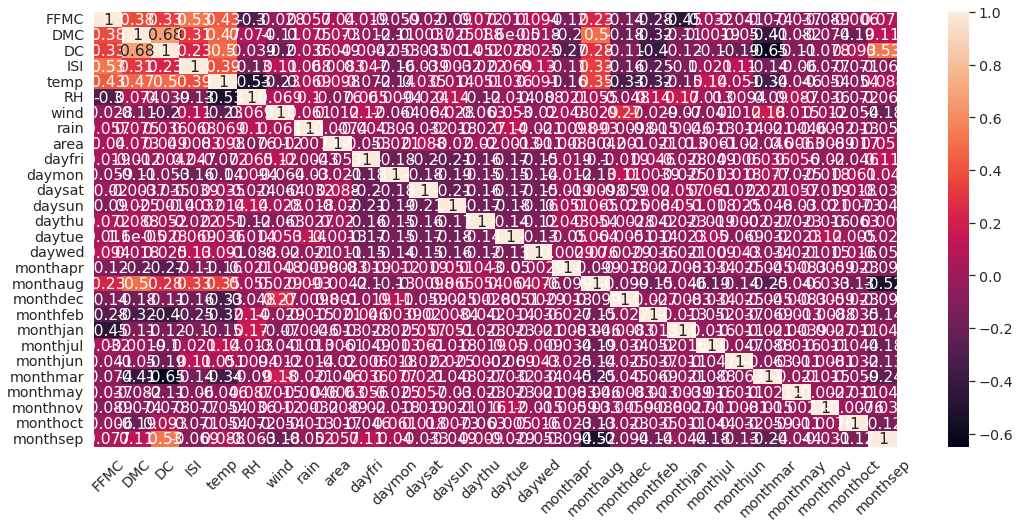

In [ ]:
fig= plt.figure(figsize=(18, 8))
sns.heatmap(forest_fire.corr(), annot=True);
plt.xticks(rotation=45)

Univariate plots

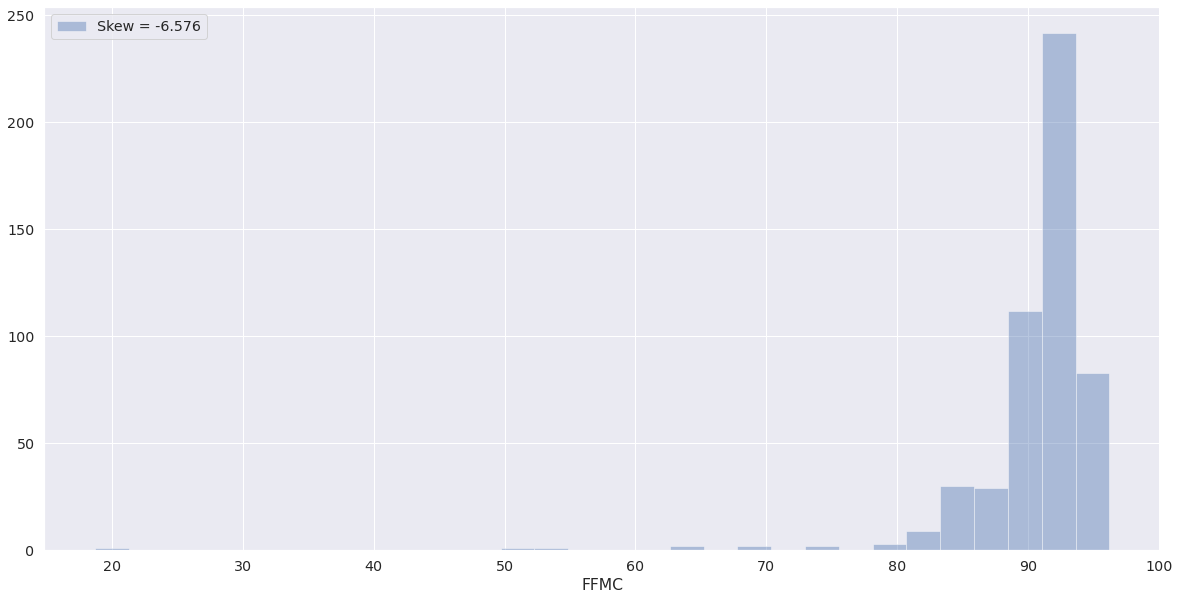

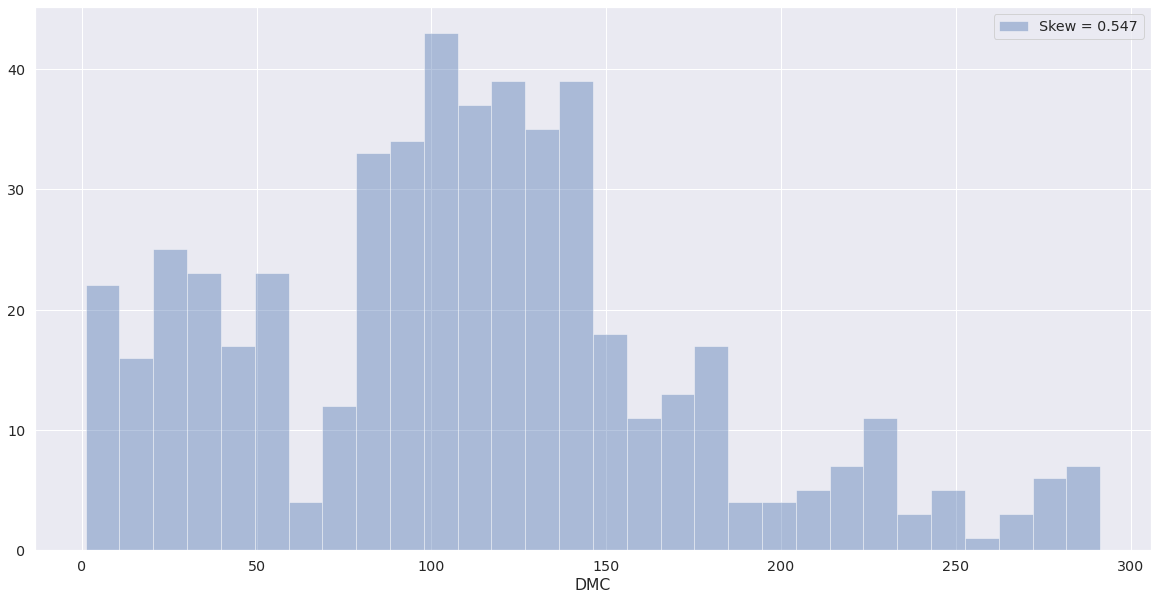

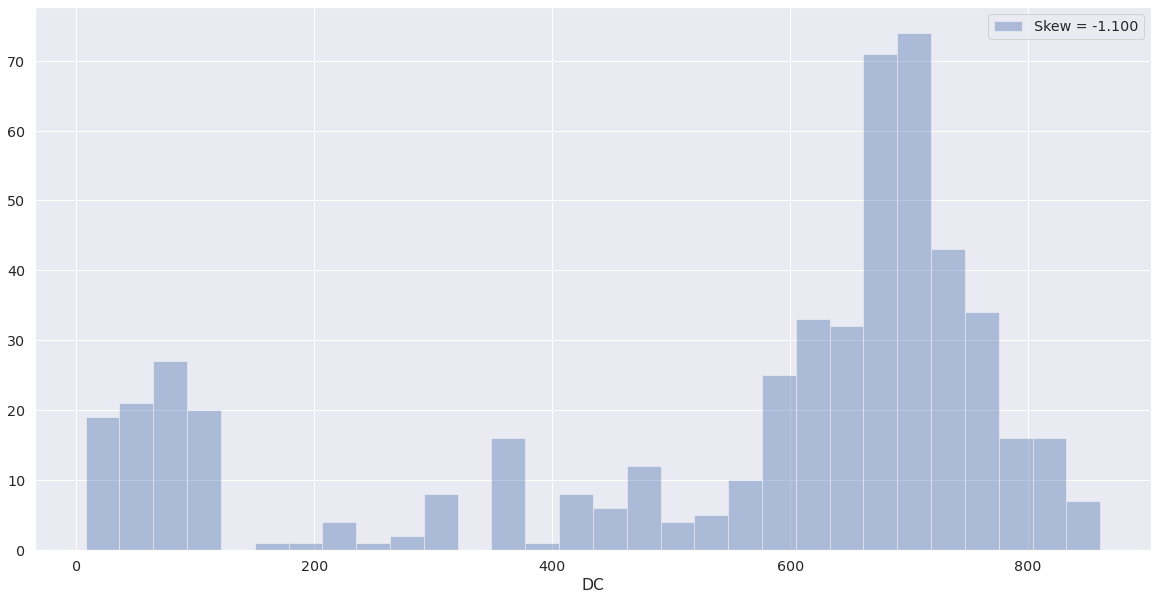

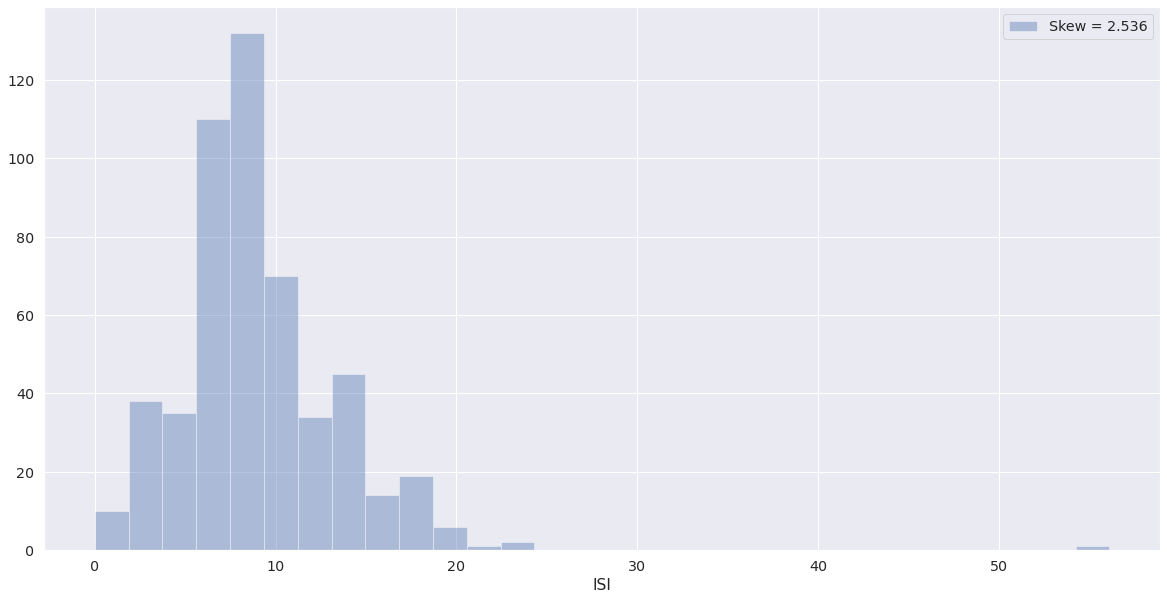

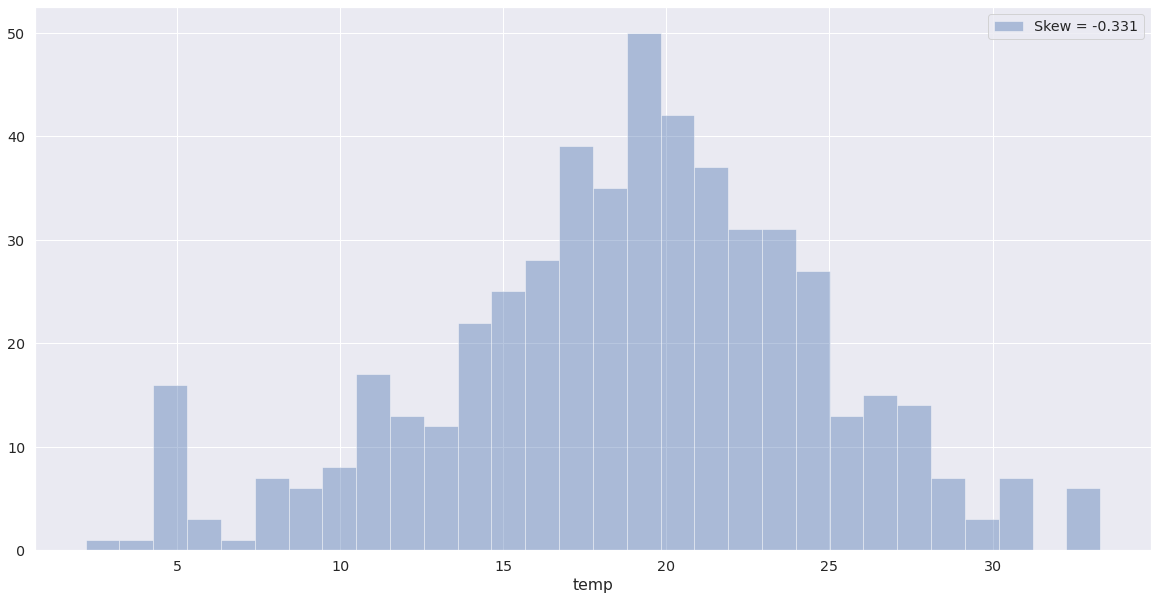

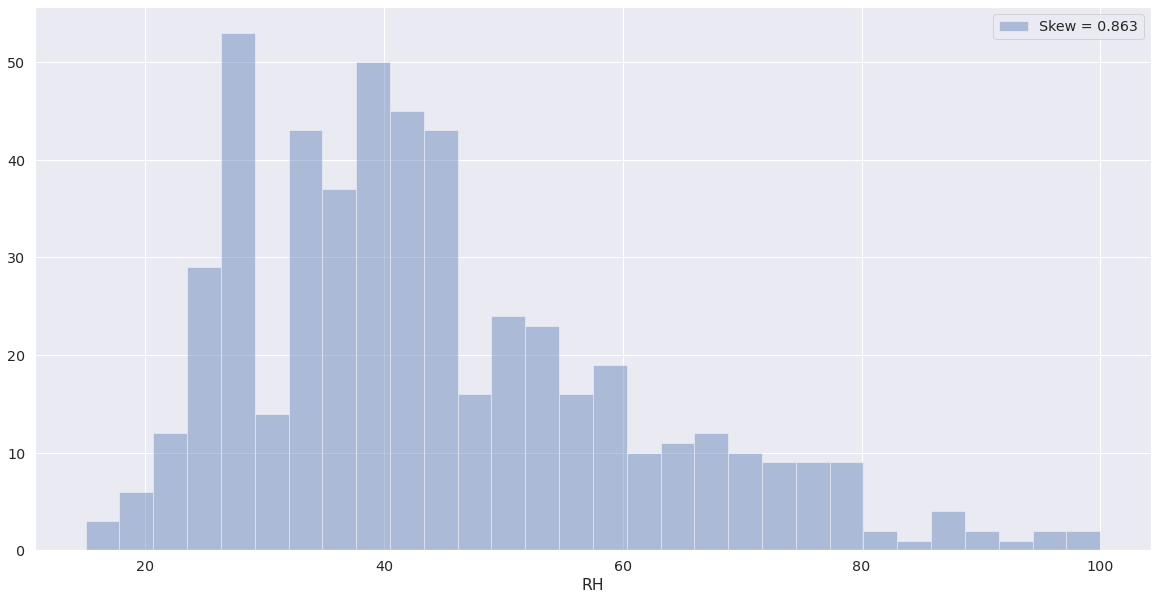

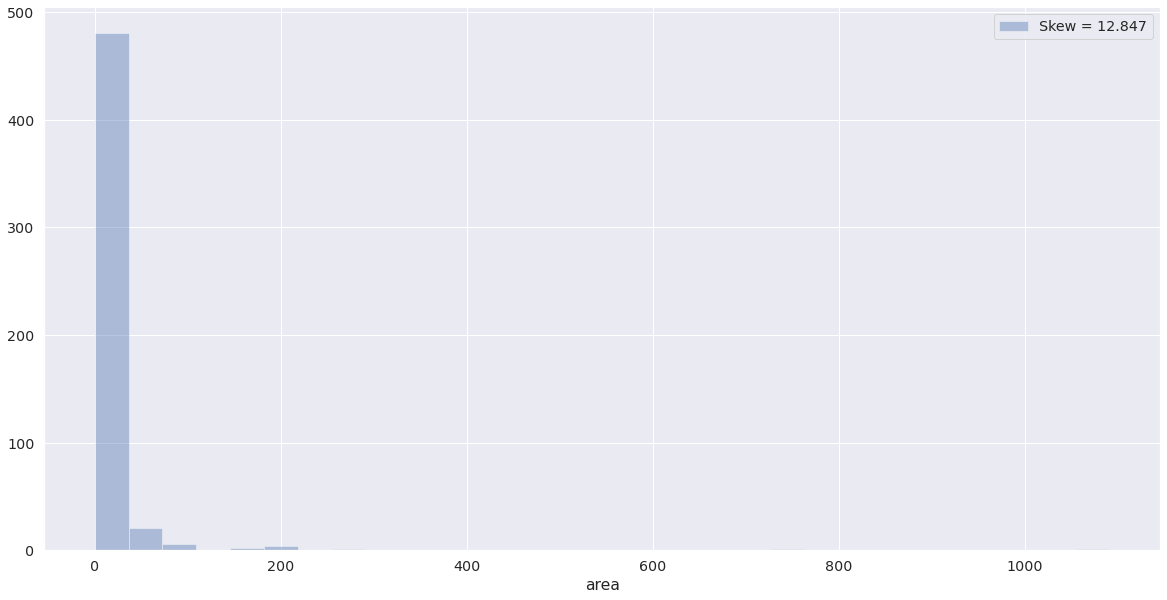

In [ ]:
for feat in continuous_feature:
    skew = forest_fire[feat].skew()
    sns.distplot(forest_fire[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers'%(len(outlier_hunt(forest_fire[continuous_feature])))) 

The dataset contains 3 observations with more than 2 outliers


In [ ]:
continuous_feature

['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'area']

Outliers Detection

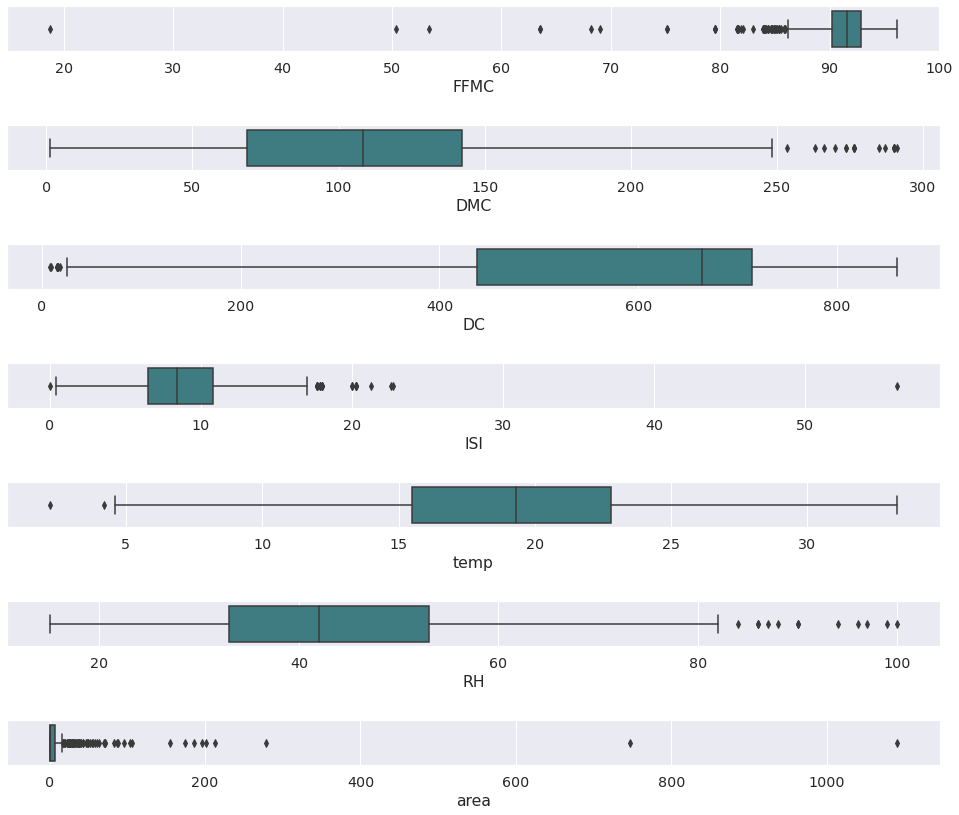

In [ ]:
ot=forest_fire.copy() 
fig, axes=plt.subplots(7,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='FFMC',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='DMC',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='DC',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='ISI',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='temp',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='RH',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='area',data=ot,palette='crest',ax=axes[6])
plt.tight_layout(pad=2.0)

After Log-Transformation

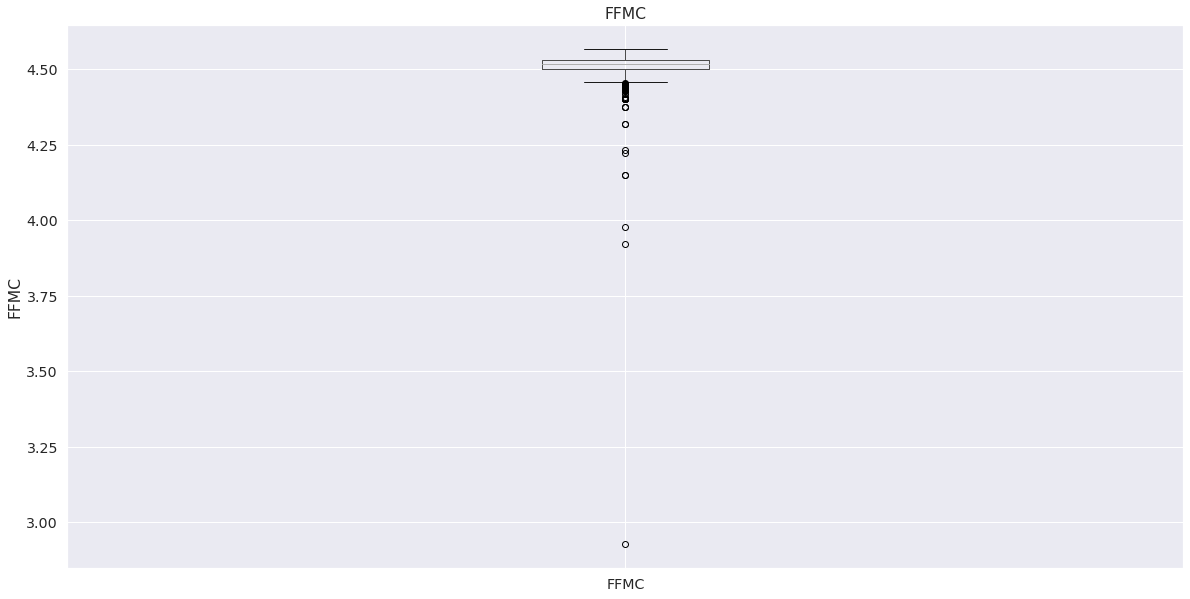

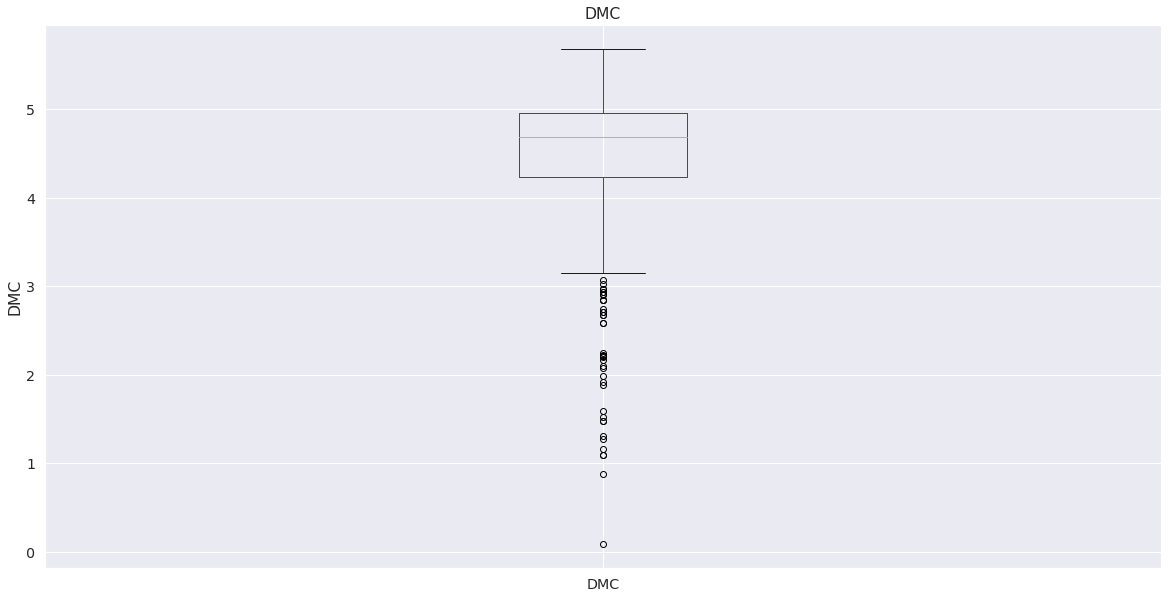

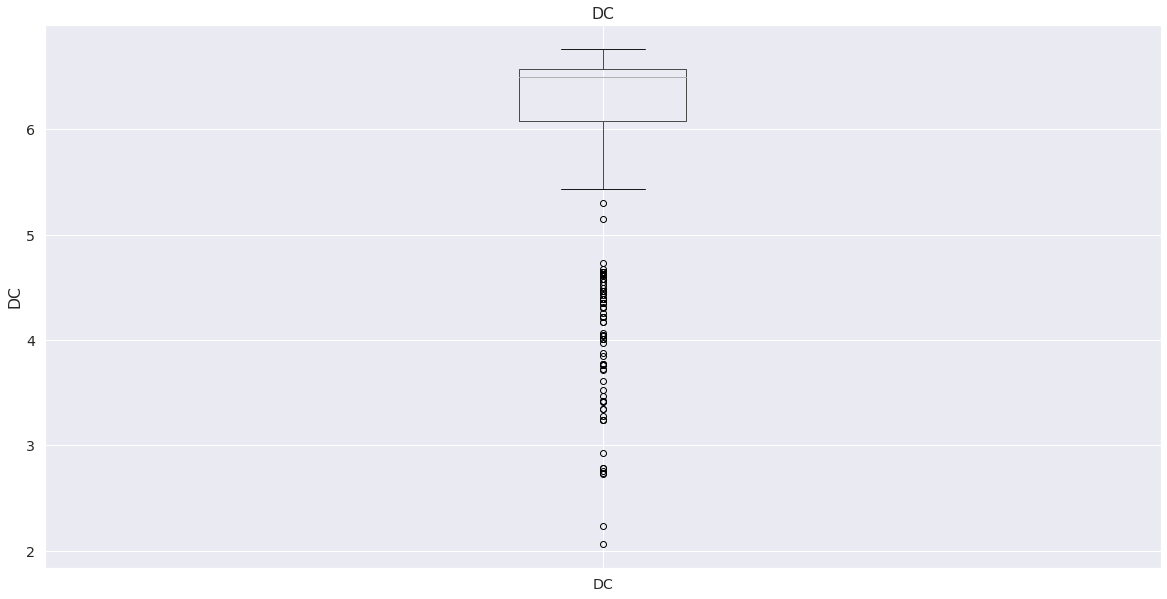

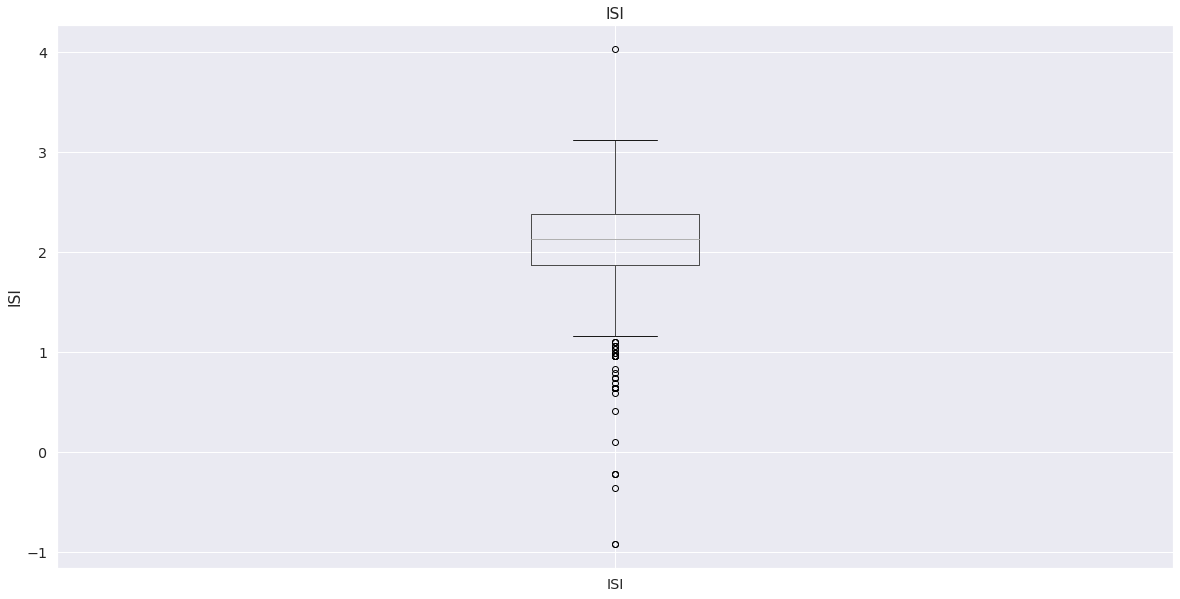

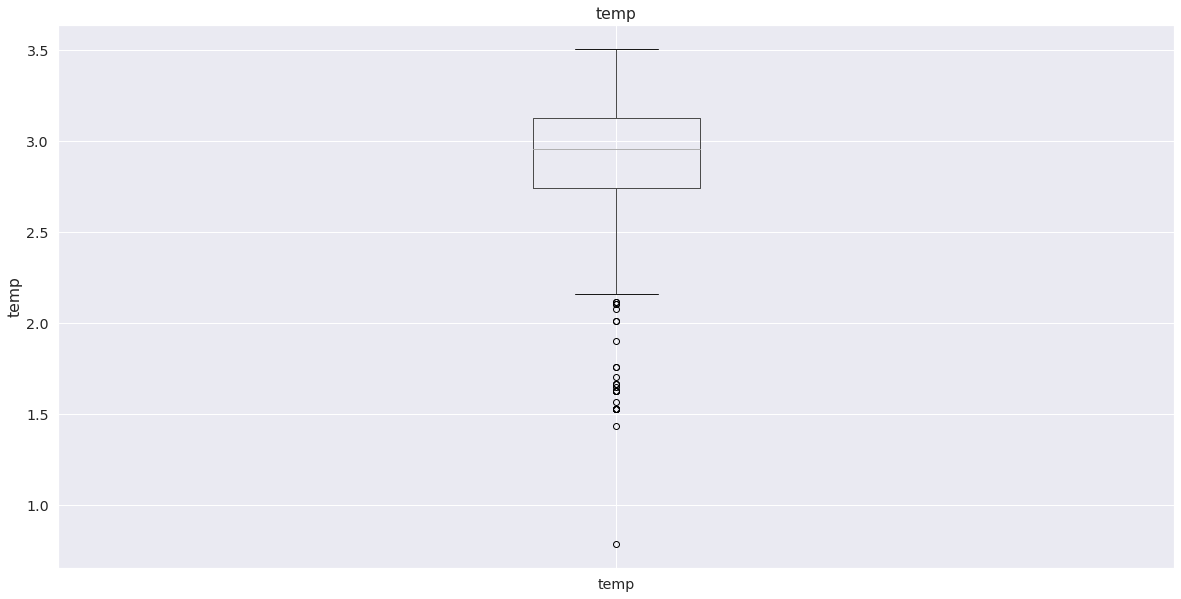

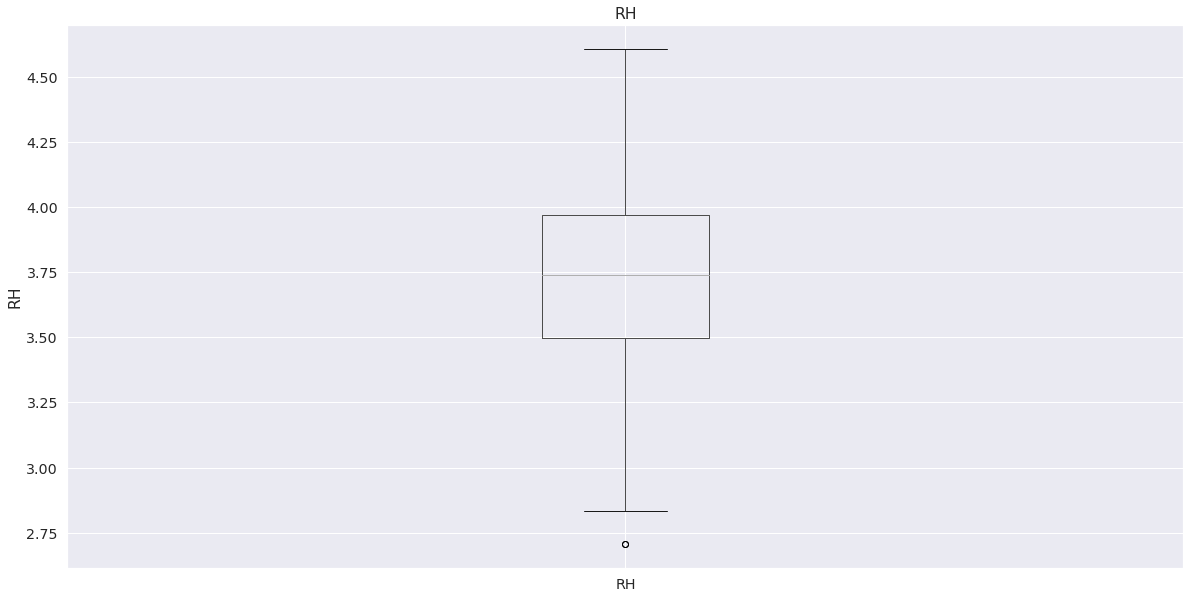

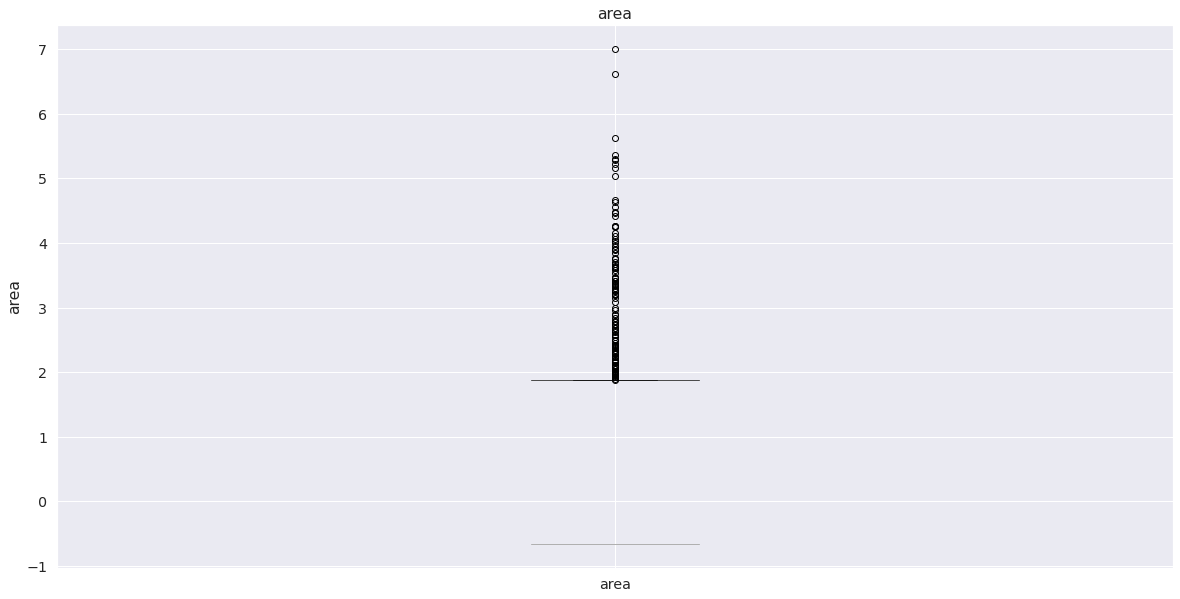

In [ ]:
for feature in continuous_feature:
    data=forest_fire.copy()
    data[feature]=np.log(data[feature])
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

Visualize the distribution of 'Area' and taking insights

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


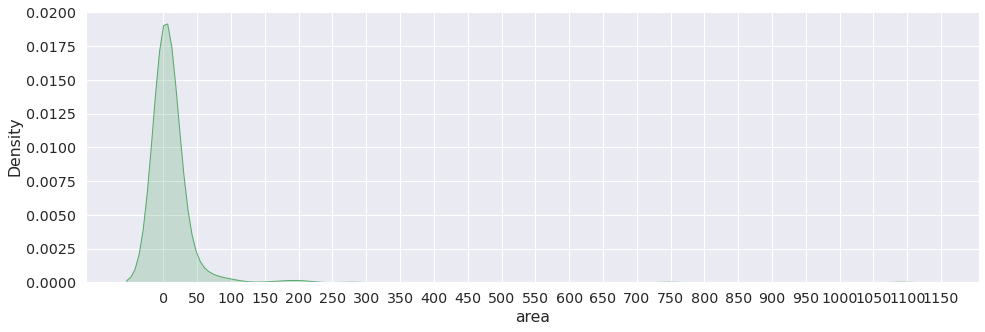

In [ ]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(forest_fire['area'].skew()))
print("Kurtosis: {}".format(forest_fire['area'].kurtosis()))
ax = sns.kdeplot(forest_fire['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

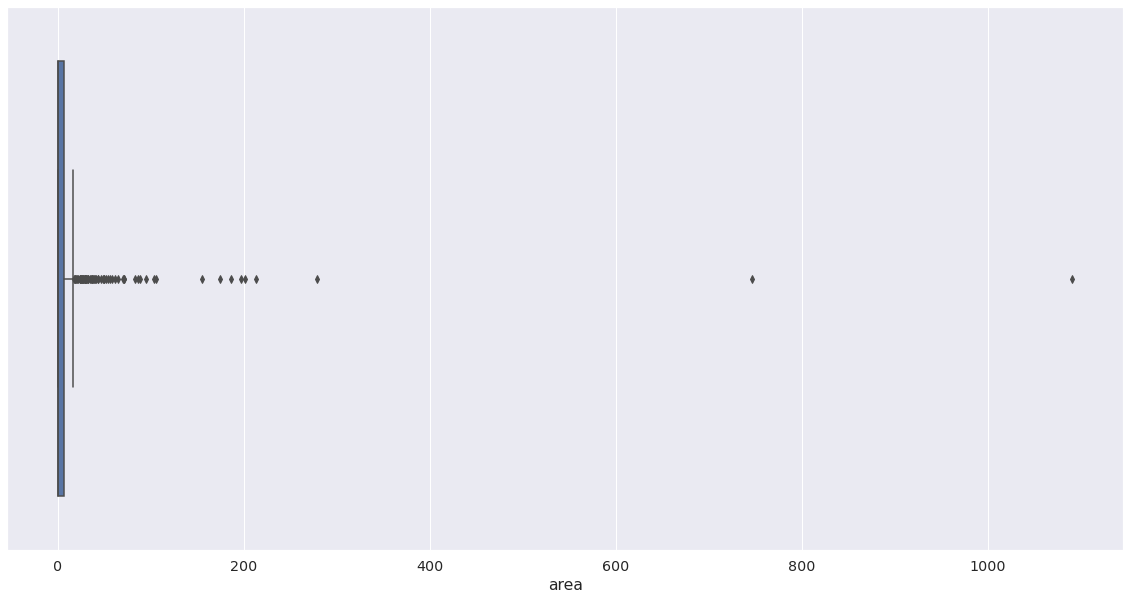

In [ ]:
ax = sns.boxplot(forest_fire['area'])

Categorical Variables

In [ ]:
categorical_features=[feature for feature in forest_fire.columns if forest_fire[feature].dtype=='O']
print('Number of Categorical Features:',len(categorical_features), '\n', categorical_features)
forest_fire[categorical_features].head()

Number of Categorical Features: 3 
 ['month', 'day', 'size_category']


month  day size_category
0   mar  fri         small
1   oct  tue         small
2   oct  sat         small
3   mar  fri         small
4   mar  sun         small

In [ ]:
for feature in categorical_features:
    print("{} number of unique categories in feature named {}".format(len(forest_fire[feature].unique()),feature))


12 number of unique categories in feature named month
7 number of unique categories in feature named day
2 number of unique categories in feature named size_category


In [ ]:
# Decide which categorical variables you want to use in model
for feature in forest_fire.columns:
    if forest_fire[feature].dtypes == 'object':# in pandas it is object
        unique_cat = len(forest_fire[feature].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=feature, unique_cat=unique_cat))
        print(forest_fire[feature].value_counts())
        print()

Feature 'month' has 12 unique categories
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

Feature 'day' has 7 unique categories
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

Feature 'size_category' has 2 unique categories
small    378
large    139
Name: size_category, dtype: int64



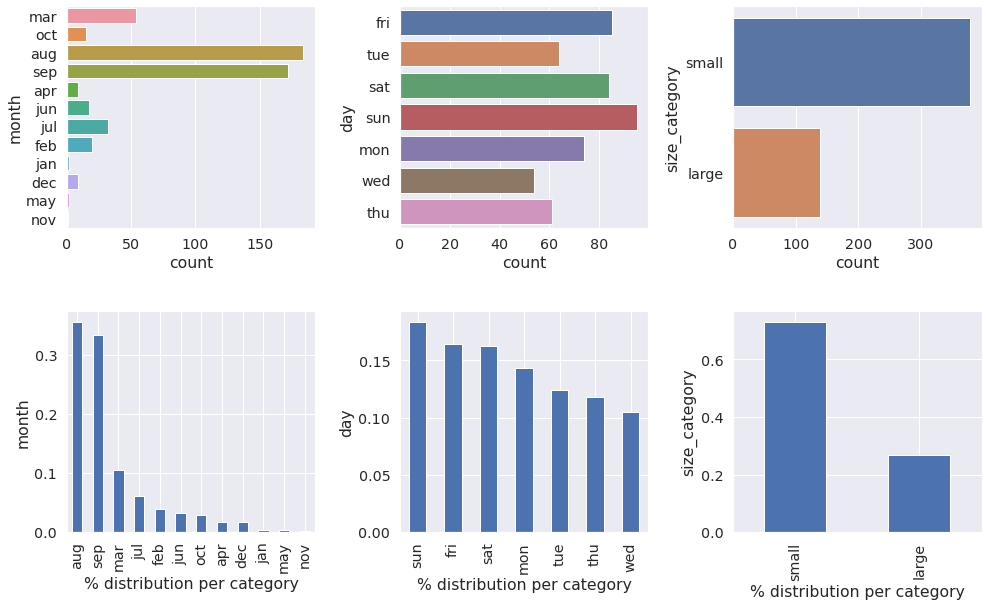

In [ ]:
# analyzing categorical columns
plt.figure(figsize=(14,12))
for i,col in enumerate(categorical_features,1):
    plt.subplot(3,3,i)
    sns.countplot(data=forest_fire,y=col)
    plt.subplot(3,3,i+3)
    forest_fire[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

Bivariate Analysis for all variables in the dataset

In [ ]:
print(forest_fire['area'].describe(),'\n')
# A categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
df=forest_fire.copy()
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 



month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  ...  monthjan  \
0   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0  ...         0   
1   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0  ...         0   
2   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0  ...         0   
3   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2  ...         0   
4   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0  ...         0   

   monthjul  monthjun  monthmar  monthmay  monthnov  monthoct  monthsep  \
0         0         0         1         0         0         0         0   
1         0         0         0         0         0         1         0   
2         0         0         0         0         0         1         0   
3         0         0         1         0         0         0         0   
4         0         0         1         0         0         0         0   

   size_category  damage_category  
0          small        No damage  
1          small        No damage  
2          small        No damage  
3          small        No damage  
4          small        No damage  

[5 rows x 32 columns]

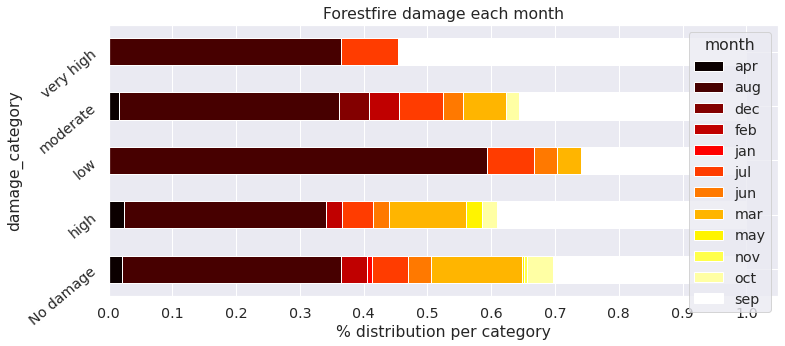

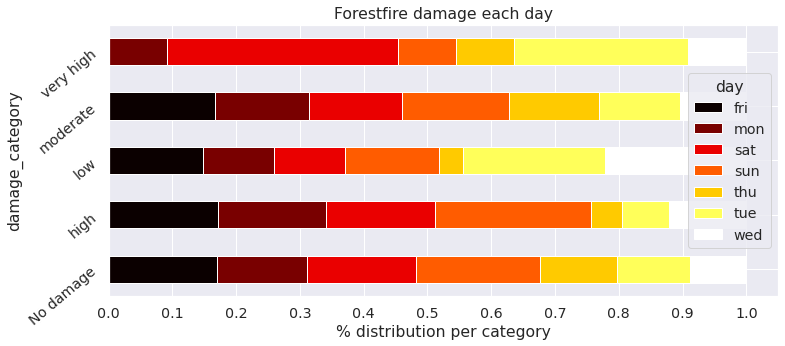

In [ ]:
for col in categorical_features:
    if col!="size_category":
        cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
        cross.plot.barh(stacked=True,rot=40,cmap='hot',figsize=(12, 5))
        plt.xlabel('% distribution per category')
        plt.xticks(np.arange(0,1.1,0.1))
        plt.title("Forestfire damage each {}".format(col))
        
plt.show()

[Text(0, 0.5, 'Temperature'),
 Text(0.5, 0, 'Months'),
 Text(0.5, 1.0, 'Month Vs Temp Barplot')]

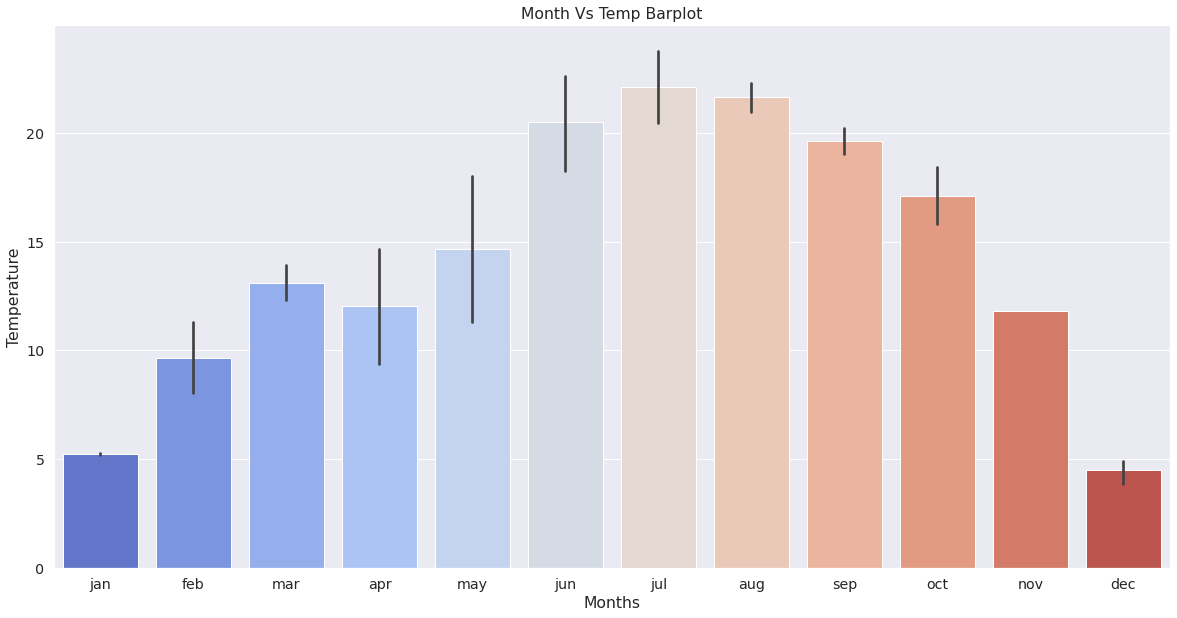

In [ ]:
# setting parameters
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = "darkgrid", font_scale = 1.3)
month_temp = sns.barplot(x = 'month', y = 'temp', data = forest_fire,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], palette = 'coolwarm');
month_temp.set(title = "Month Vs Temp Barplot", xlabel = "Months", ylabel = "Temperature")


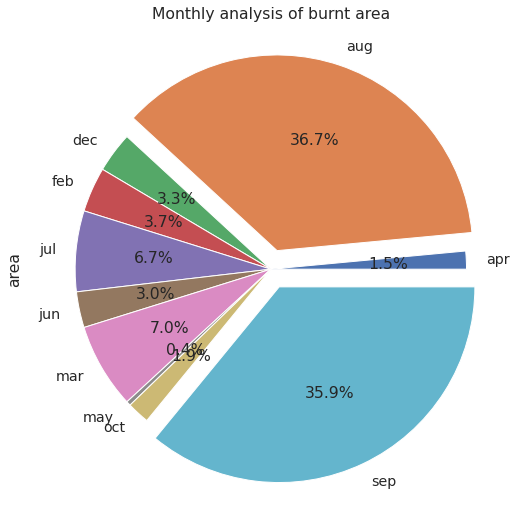

In [ ]:
# monthly analysis of burnt area, where the condition is: area>0
areaburnt=forest_fire[forest_fire['area']>0]
areaburnt.groupby('month')['area'].agg('count').plot(kind='pie',title='Monthly analysis of burnt area',figsize=(9,9),explode=[0,0.1,0,0,0,0,0,0,0,0.1],autopct='%0.1f%%')
plt.show()

Visualize the Large Forest Fire Size rate by month

In [ ]:
df1=forest_fire.copy()
order={'month':{'jan':'January','feb':'February','mar':'March','apr':'April','may':'May','jun':'June','jul':'July','aug':'August','sep':'September','oct':'October','nov':'November','dec':'December'}}
df1=df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
month

% Small Forest Fire  % Large Forest Fire
January             100.000000             0.000000
February             70.000000            30.000000
March                77.777778            22.222222
April                77.777778            22.222222
May                  50.000000            50.000000
June                 82.352941            17.647059
July                 71.875000            28.125000
August               76.630435            23.369565
September            70.348837            29.651163
October              73.333333            26.666667
November            100.000000             0.000000
December             11.111111            88.888889

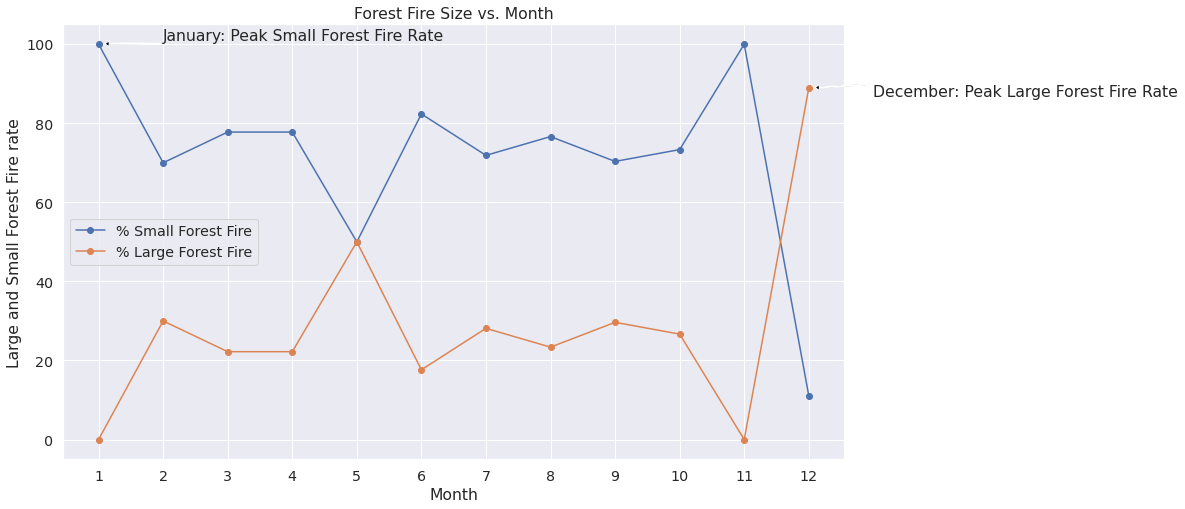

In [ ]:
# Step 4: Change 'month' from words to numbers for easier analysis
df1=forest_fire.copy()
order={'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df1=df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['Month'] = ['August','September','March','July','February','June','October','April','December','January','May','November']
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
plot_month = month[['% Small Forest Fire','% Large Forest Fire']].plot(kind ='line',
                                                          figsize = (14,8),
                                                          marker = 'o')

plt.title('Forest Fire Size vs. Month')
plt.ylabel('Large and Small Forest Fire rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of Small fire rate
y = month['% Small Forest Fire'].max()
x = month['% Small Forest Fire'].idxmax()
plt.annotate('January: Peak Small Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of large fire rate
y = month['% Large Forest Fire'].max()
x = month['% Large Forest Fire'].idxmax()
plt.annotate('December: Peak Large Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

In [ ]:
data_ = forest_fire.copy()
data_.drop('size_category',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  dayfri  ...  month_nov  \
0  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0       1  ...          0   
1  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0       0  ...          0   
2  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0       0  ...          0   
3  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0       1  ...          0   
4  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0       0  ...          0   

   month_oct  month_sep  day_fri  day_mon  day_sat  day_sun  day_thu  day_tue  \
0          0          0        1        0        0        0        0        0   
1          1          0        0        0        0        0        0        1   
2          1          0        0        0        1        0        0        0   
3          0          0        1        0        0        0        0        0   
4          0          0        0        0        0        1        0        0   

   day_wed  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 46 columns]

Text(0.5, 1.0, 'Correlation with Forest Fire Size Category \n')

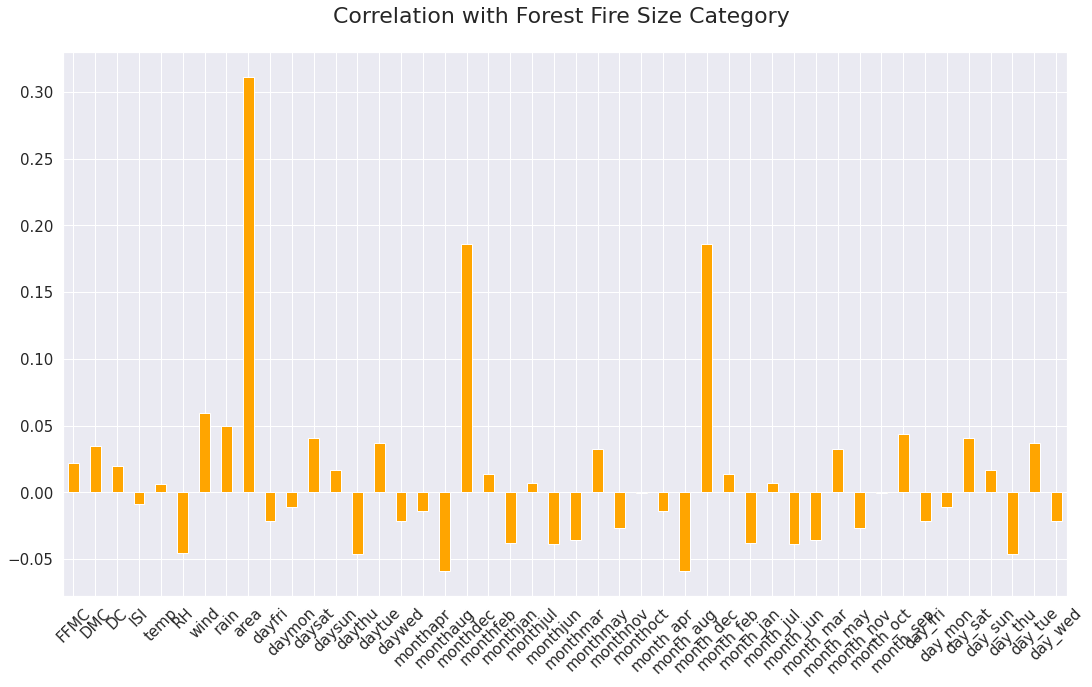

In [ ]:
df=forest_fire.copy()
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)

correlations = data_.corrwith(df.size_category)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Forest Fire Size Category \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

Analysis of the response column

In [ ]:
forest_fire.size_category.unique()

array(['small', 'large'], dtype=object)

Checking for Imbalanced or balanced dataset with regards to the Target

In [ ]:
countsizesmall = len(forest_fire[forest_fire.size_category == 'small'])
countsizelarge = len(forest_fire[forest_fire.size_category == 'large'])
print("Percentage of Small Forest Fire Size: {:.2f}%".format((countsizesmall / (len(forest_fire.size_category))*100)))
print("Percentage of Large Foreset Fire Size: {:.2f}%".format((countsizelarge / (len(forest_fire.size_category))*100)))


Percentage of Small Forest Fire Size: 73.11%
Percentage of Large Foreset Fire Size: 26.89%


In [ ]:
forest_fire.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

Text(0.5, 1.0, 'Foeest Fire Size Category')

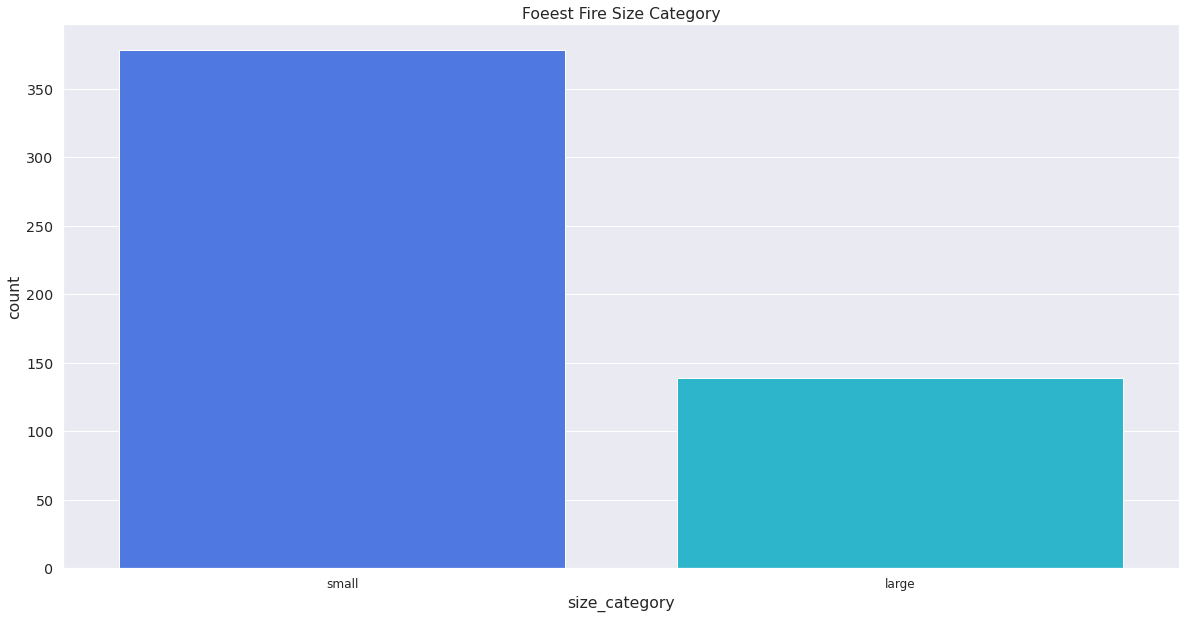

In [ ]:
pal = sns.color_palette('rainbow')
sns.countplot(x='size_category', data=forest_fire, palette = pal, 
              order=forest_fire['size_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Foeest Fire Size Category')

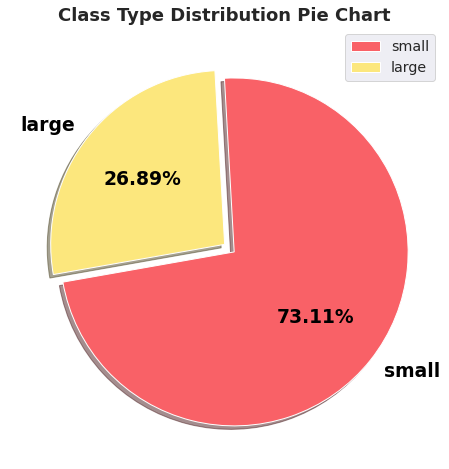

In [ ]:
plt.figure(figsize = (12,8))
plt.pie(forest_fire['size_category'].value_counts(),
       labels=forest_fire.size_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
        colors = ["#F96167", "#FCE77D"],
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

Feature Engineering

In [ ]:
continuous_feature=[feature for feature in forest_fire.columns if forest_fire[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 28


In [ ]:
forest_fire[continuous_feature]

FFMC    DMC     DC   ISI  temp  RH  wind  rain   area  dayfri  ...  \
0    86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00       1  ...   
1    90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00       0  ...   
2    90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00       0  ...   
3    91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00       1  ...   
4    89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00       0  ...   
..    ...    ...    ...   ...   ...  ..   ...   ...    ...     ...  ...   
512  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44       0  ...   
513  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29       0  ...   
514  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16       0  ...   
515  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00       0  ...   
516  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00       0  ...   

     monthdec  monthfeb  monthjan  monthjul  monthjun  monthmar  monthmay  \
0           0         0         0         0         0         1         0   
1           0         0         0         0         0         0         0   
2           0         0         0         0         0         0         0   
3           0         0         0         0         0         1         0   
4           0         0         0         0         0         1         0   
..        ...       ...       ...       ...       ...       ...       ...   
512         0         0         0         0         0         0         0   
513         0         0         0         0         0         0         0   
514         0         0         0         0         0         0         0   
515         0         0         0         0         0         0         0   
516         0         0         0         0         0         0         0   

     monthnov  monthoct  monthsep  
0           0         0         0  
1           0         1         0  
2           0         1         0  
3           0         0         0  
4           0         0         0  
..        ...       ...       ...  
512         0         0         0  
513         0         0         0  
514         0         0         0  
515         0         0         0  
516         1         0         0  

[517 rows x 28 columns]

In [ ]:
df_standard_scaled = forest_fire.copy()
features = df_standard_scaled[continuous_feature]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

month  day      FFMC       DMC        DC       ISI      temp        RH  \
0   mar  fri -0.805959 -1.323326 -1.830477 -0.860946 -1.842640  0.411724   
1   oct  tue -0.008102 -1.179541  0.488891 -0.509688 -0.153278 -0.692456   
2   oct  sat -0.008102 -1.049822  0.560715 -0.509688 -0.739383 -0.692456   
3   mar  fri  0.191362 -1.212361 -1.898266 -0.004756 -1.825402  3.233519   
4   mar  sun -0.243833 -0.931043 -1.798600  0.126966 -1.291012  3.356206   

       wind      rain  ...  monthfeb  monthjan  monthjul  monthjun  monthmar  \
0  1.498614 -0.073268  ... -0.200603 -0.062318 -0.256865 -0.184391  2.928152   
1 -1.741756 -0.073268  ... -0.200603 -0.062318 -0.256865 -0.184391 -0.341512   
2 -1.518282 -0.073268  ... -0.200603 -0.062318 -0.256865 -0.184391 -0.341512   
3 -0.009834  0.603155  ... -0.200603 -0.062318 -0.256865 -0.184391  2.928152   
4 -1.238940 -0.073268  ... -0.200603 -0.062318 -0.256865 -0.184391  2.928152   

   monthmay  monthnov  monthoct  monthsep  size_category  
0 -0.062318 -0.044023 -0.172860 -0.706081          small  
1 -0.062318 -0.044023  5.785038 -0.706081          small  
2 -0.062318 -0.044023  5.785038 -0.706081          small  
3 -0.062318 -0.044023 -0.172860 -0.706081          small  
4 -0.062318 -0.044023 -0.172860 -0.706081          small  

[5 rows x 31 columns]

In [ ]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Devaition','\n',np.round(df_standard_scaled.std()),1)


Mean
 FFMC       -0.0
DMC        -0.0
DC          0.0
ISI         0.0
temp        0.0
RH          0.0
wind       -0.0
rain       -0.0
area        0.0
dayfri      0.0
daymon     -0.0
daysat     -0.0
daysun     -0.0
daythu     -0.0
daytue      0.0
daywed      0.0
monthapr    0.0
monthaug    0.0
monthdec   -0.0
monthfeb    0.0
monthjan    0.0
monthjul   -0.0
monthjun   -0.0
monthmar   -0.0
monthmay   -0.0
monthnov   -0.0
monthoct    0.0
monthsep    0.0
dtype: float64 
Standard Devaition 
 FFMC        1.0
DMC         1.0
DC          1.0
ISI         1.0
temp        1.0
RH          1.0
wind        1.0
rain        1.0
area        1.0
dayfri      1.0
daymon      1.0
daysat      1.0
daysun      1.0
daythu      1.0
daytue      1.0
daywed      1.0
monthapr    1.0
monthaug    1.0
monthdec    1.0
monthfeb    1.0
monthjan    1.0
monthjul    1.0
monthjun    1.0
monthmar    1.0
monthmay    1.0
monthnov    1.0
monthoct    1.0
monthsep    1.0
dtype: float64 1


In [ ]:
df = df_standard_scaled.copy()
df.drop('size_category',axis=1, inplace =True)
df = pd.get_dummies(df.iloc[:,:])
df.head()

FFMC       DMC        DC       ISI      temp        RH      wind  \
0 -0.805959 -1.323326 -1.830477 -0.860946 -1.842640  0.411724  1.498614   
1 -0.008102 -1.179541  0.488891 -0.509688 -0.153278 -0.692456 -1.741756   
2 -0.008102 -1.049822  0.560715 -0.509688 -0.739383 -0.692456 -1.518282   
3  0.191362 -1.212361 -1.898266 -0.004756 -1.825402  3.233519 -0.009834   
4 -0.243833 -0.931043 -1.798600  0.126966 -1.291012  3.356206 -1.238940   

       rain     area    dayfri  ...  month_nov  month_oct  month_sep  day_fri  \
0 -0.073268 -0.20202  2.254407  ...          0          0          0        1   
1 -0.073268 -0.20202 -0.443576  ...          0          1          0        0   
2 -0.073268 -0.20202 -0.443576  ...          0          1          0        0   
3  0.603155 -0.20202  2.254407  ...          0          0          0        1   
4 -0.073268 -0.20202 -0.443576  ...          0          0          0        0   

   day_mon  day_sat  day_sun  day_thu  day_tue  day_wed  
0        0        0        0        0        0        0  
1        0        0        0        0        1        0  
2        0        1        0        0        0        0  
3        0        0        0        0        0        0  
4        0        0        1        0        0        0  

[5 rows x 47 columns]

Converting Categorical Variable into Label by using Get Dummies FeatureData Pre-Processing

In [ ]:
df['size_category'] = forest_fire.size_category
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)
df.head()

FFMC       DMC        DC       ISI      temp        RH      wind  \
0 -0.805959 -1.323326 -1.830477 -0.860946 -1.842640  0.411724  1.498614   
1 -0.008102 -1.179541  0.488891 -0.509688 -0.153278 -0.692456 -1.741756   
2 -0.008102 -1.049822  0.560715 -0.509688 -0.739383 -0.692456 -1.518282   
3  0.191362 -1.212361 -1.898266 -0.004756 -1.825402  3.233519 -0.009834   
4 -0.243833 -0.931043 -1.798600  0.126966 -1.291012  3.356206 -1.238940   

       rain     area    dayfri  ...  month_oct  month_sep  day_fri  day_mon  \
0 -0.073268 -0.20202  2.254407  ...          0          0        1        0   
1 -0.073268 -0.20202 -0.443576  ...          1          0        0        0   
2 -0.073268 -0.20202 -0.443576  ...          1          0        0        0   
3  0.603155 -0.20202  2.254407  ...          0          0        1        0   
4 -0.073268 -0.20202 -0.443576  ...          0          0        0        0   

   day_sat  day_sun  day_thu  day_tue  day_wed  size_category  
0        0        0        0        0        0              0  
1        0        0        0        1        0              0  
2        1        0        0        0        0              0  
3        0        0        0        0        0              0  
4        0        1        0        0        0              0  

[5 rows x 48 columns]

In [ ]:
df.size_category.unique()

array([0, 1])

 Test Train Split With Imbalanced Dataset

In [ ]:
x = forest_fire.drop('size_category',axis=1)
y = forest_fire[['size_category']]

In [ ]:
# Splitting data into test data and train data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3, stratify=y)


In [ ]:
len(x_train.columns)

30

In [ ]:
dataset = forest_fire.values


X = dataset[:,0:12]
Y = dataset[:,12]

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import RFE

In [ ]:
print("Correlation:", forest_fire.corr(method='pearson'))

Correlation:               FFMC       DMC        DC       ISI      temp        RH  \
FFMC      1.000000  0.382619  0.330512  0.531805  0.431532 -0.300995   
DMC       0.382619  1.000000  0.682192  0.305128  0.469594  0.073795   
DC        0.330512  0.682192  1.000000  0.229154  0.496208 -0.039192   
ISI       0.531805  0.305128  0.229154  1.000000  0.394287 -0.132517   
temp      0.431532  0.469594  0.496208  0.394287  1.000000 -0.527390   
RH       -0.300995  0.073795 -0.039192 -0.132517 -0.527390  1.000000   
wind     -0.028485 -0.105342 -0.203466  0.106826 -0.227116  0.069410   
rain      0.056702  0.074790  0.035861  0.067668  0.069491  0.099751   
area      0.040122  0.072994  0.049383  0.008258  0.097844 -0.075519   
dayfri    0.019306 -0.012010 -0.004220  0.046695 -0.071949  0.064506   
daymon   -0.059396 -0.107921 -0.052993 -0.158601 -0.136529  0.009376   
daysat   -0.019637 -0.003653 -0.035189 -0.038585  0.034899 -0.023869   
daysun   -0.089517  0.025355 -0.001431 -0.003243  0

In [ ]:
print("Statistical Description:",forest_fire.describe())

Statistical Description:              FFMC         DMC          DC         ISI        temp          RH  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean    90.644681  110.872340  547.940039    9.021663   18.889168   44.288201   
std      5.520111   64.046482  248.066192    4.559477    5.806625   16.317469   
min     18.700000    1.100000    7.900000    0.000000    2.200000   15.000000   
25%     90.200000   68.600000  437.700000    6.500000   15.500000   33.000000   
50%     91.600000  108.300000  664.200000    8.400000   19.300000   42.000000   
75%     92.900000  142.400000  713.900000   10.800000   22.800000   53.000000   
max     96.200000  291.300000  860.600000   56.100000   33.300000  100.000000   

             wind        rain         area      dayfri  ...    monthdec  \
count  517.000000  517.000000   517.000000  517.000000  ...  517.000000   
mean     4.017602    0.021663    12.847292    0.164410  ...    0.017408   
std      1.791653   

In [ ]:
print("Correlation:", forest_fire.corr(method='pearson'))

Correlation:               FFMC       DMC        DC       ISI      temp        RH  \
FFMC      1.000000  0.382619  0.330512  0.531805  0.431532 -0.300995   
DMC       0.382619  1.000000  0.682192  0.305128  0.469594  0.073795   
DC        0.330512  0.682192  1.000000  0.229154  0.496208 -0.039192   
ISI       0.531805  0.305128  0.229154  1.000000  0.394287 -0.132517   
temp      0.431532  0.469594  0.496208  0.394287  1.000000 -0.527390   
RH       -0.300995  0.073795 -0.039192 -0.132517 -0.527390  1.000000   
wind     -0.028485 -0.105342 -0.203466  0.106826 -0.227116  0.069410   
rain      0.056702  0.074790  0.035861  0.067668  0.069491  0.099751   
area      0.040122  0.072994  0.049383  0.008258  0.097844 -0.075519   
dayfri    0.019306 -0.012010 -0.004220  0.046695 -0.071949  0.064506   
daymon   -0.059396 -0.107921 -0.052993 -0.158601 -0.136529  0.009376   
daysat   -0.019637 -0.003653 -0.035189 -0.038585  0.034899 -0.023869   
daysun   -0.089517  0.025355 -0.001431 -0.003243  0

In [ ]:
dataset = forest_fire.values


X = dataset[:,0:12]
Y = dataset[:,12]


(array([508.,   6.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.   ,  109.084,  218.168,  327.252,  436.336,  545.42 ,
         654.504,  763.588,  872.672,  981.756, 1090.84 ]),
 <a list of 10 Patch objects>)

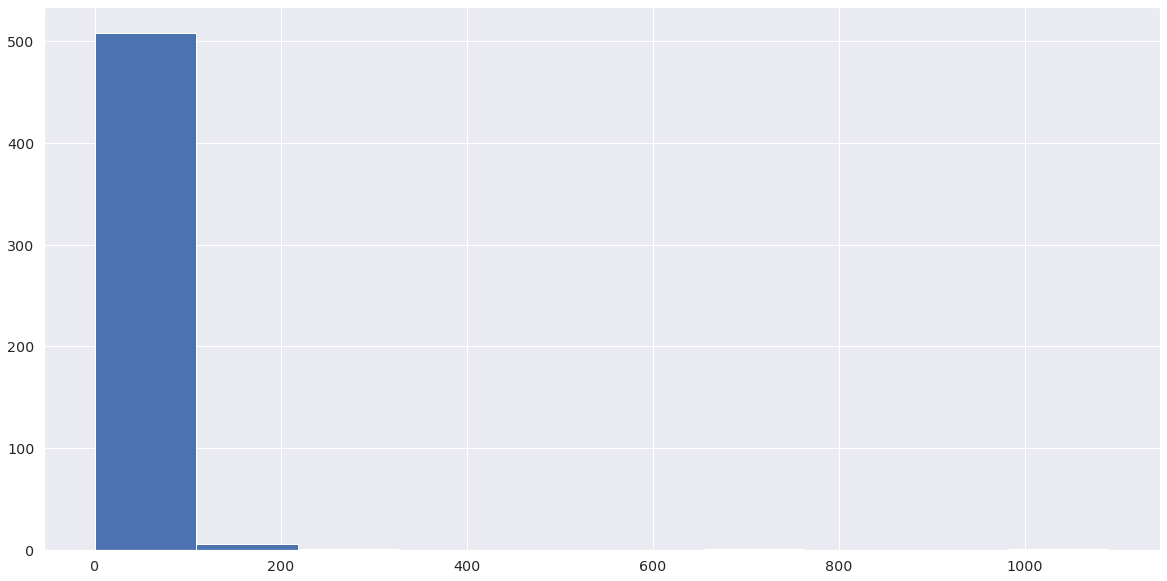

In [ ]:
plt.hist((forest_fire.area))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f778691b1f0>,
      dtype=object)

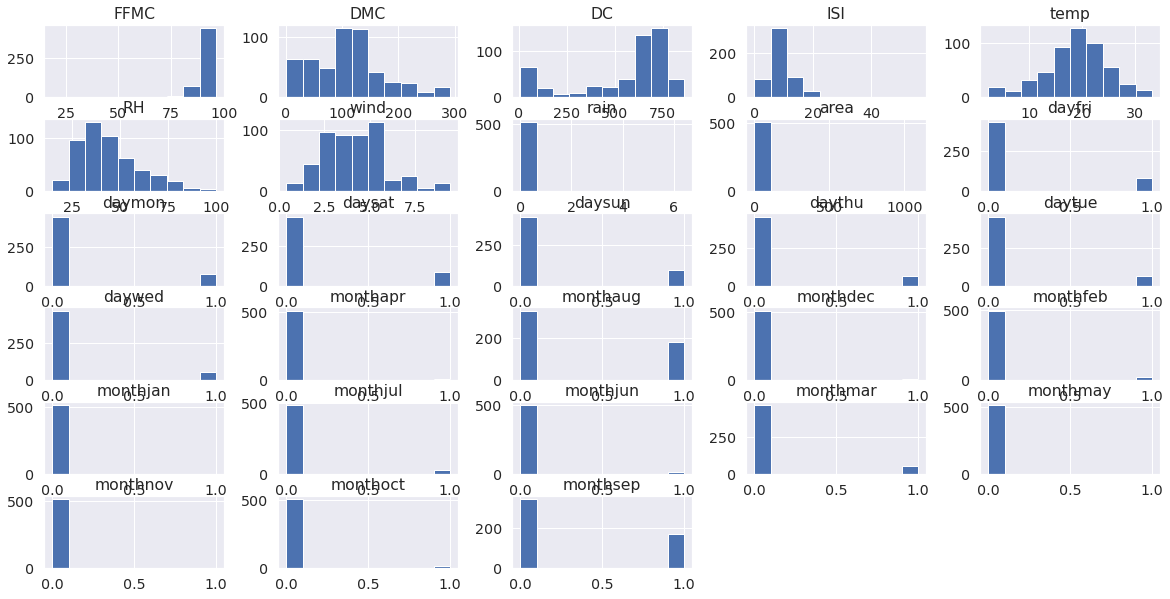

In [ ]:
forest_fire.hist()

[Text(0, 0, 'month'),
 Text(0, 0, 'day'),
 Text(0, 0, 'FFMC'),
 Text(0, 0, 'DMC'),
 Text(0, 0, 'DC'),
 Text(0, 0, 'ISI'),
 Text(0, 0, 'temp'),
 Text(0, 0, 'RH'),
 Text(0, 0, 'wind'),
 Text(0, 0, 'rain'),
 Text(0, 0, 'area'),
 Text(0, 0, 'dayfri')]

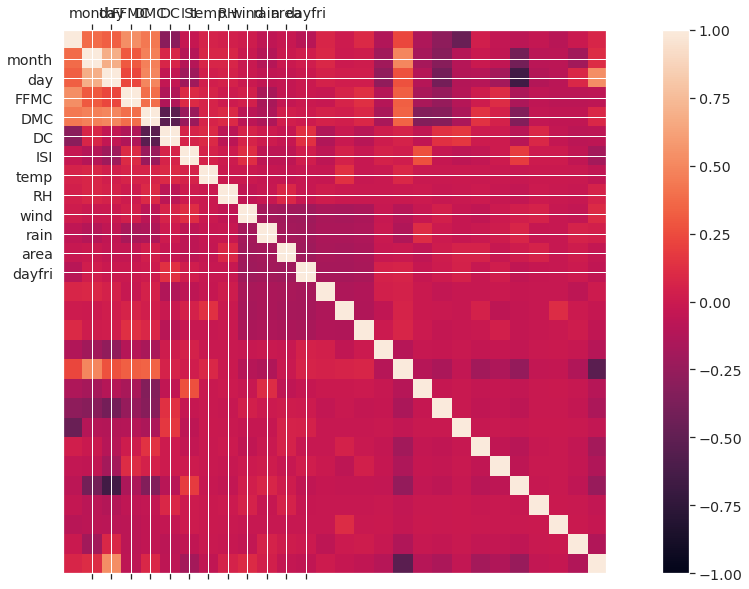

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(forest_fire.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(forest_fire.columns)
ax.set_yticklabels(forest_fire.columns)

2]The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine. 
The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.



Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.


In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from imblearn.pipeline import Pipeline
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving gas_turbines.csv to gas_turbines.csv


In [ ]:
df=pd.read_csv('gas_turbines.csv')

In [ ]:
df

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0      6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1      6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2      6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3      7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4      7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15034  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  111.61  10.400   
15035  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  111.78  10.433   
15036  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  110.19  10.483   
15037  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  110.74  10.533   
15038  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  111.58  10.583   

           CO     NOX  
0      3.1547  82.722  
1      3.2363  82.776  
2      3.2012  82.468  
3      3.1923  82.670  
4      3.2484  82.311  
...       ...     ...  
15034  4.5186  79.559  
15035  4.8470  79.917  
15036  7.9632  90.912  
15037  6.2494  93.227  
15038  4.9816  92.498  

[15039 rows x 11 columns]


Data Exploration

In [ ]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [ ]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

Descriptive Analysis

In [ ]:
df.shape

(15039, 11)

In [ ]:
#Checking the data types
df.dtypes


AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [ ]:
#Unique values for every feature
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [ ]:
df[df.duplicated()].shape

(0, 11)

In [ ]:
df[df.duplicated()]

Empty DataFrame
Columns: [AT, AP, AH, AFDP, GTEP, TIT, TAT, TEY, CDP, CO, NOX]
Index: []

In [ ]:
df.describe().T

count         mean        std          min          25%        50%  \
AT    15039.0    17.764381   7.574323     0.522300    11.408000    18.1860   
AP    15039.0  1013.199240   6.410760   985.850000  1008.900000  1012.8000   
AH    15039.0    79.124174  13.793439    30.344000    69.750000    82.2660   
AFDP  15039.0     4.200294   0.760197     2.087400     3.723900     4.1862   
GTEP  15039.0    25.419061   4.173916    17.878000    23.294000    25.0820   
TIT   15039.0  1083.798770  16.527806  1000.800000  1079.600000  1088.7000   
TAT   15039.0   545.396183   7.866803   512.450000   542.170000   549.8900   
TEY   15039.0   134.188464  15.829717   100.170000   127.985000   133.7800   
CDP   15039.0    12.102353   1.103196     9.904400    11.622000    12.0250   
CO    15039.0     1.972499   2.222206     0.000388     0.858055     1.3902   
NOX   15039.0    68.190934  10.470586    27.765000    61.303500    66.6010   

            75%        max  
AT      23.8625    34.9290  
AP    1016.9000  1034.2000  
AH      90.0435   100.2000  
AFDP     4.5509     7.6106  
GTEP    27.1840    37.4020  
TIT   1096.0000  1100.8000  
TAT    550.0600   550.6100  
TEY    140.8950   174.6100  
CDP     12.5780    15.0810  
CO       2.1604    44.1030  
NOX     73.9355   119.8900

In [ ]:
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [ ]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

Data Visualization

Univariate plots

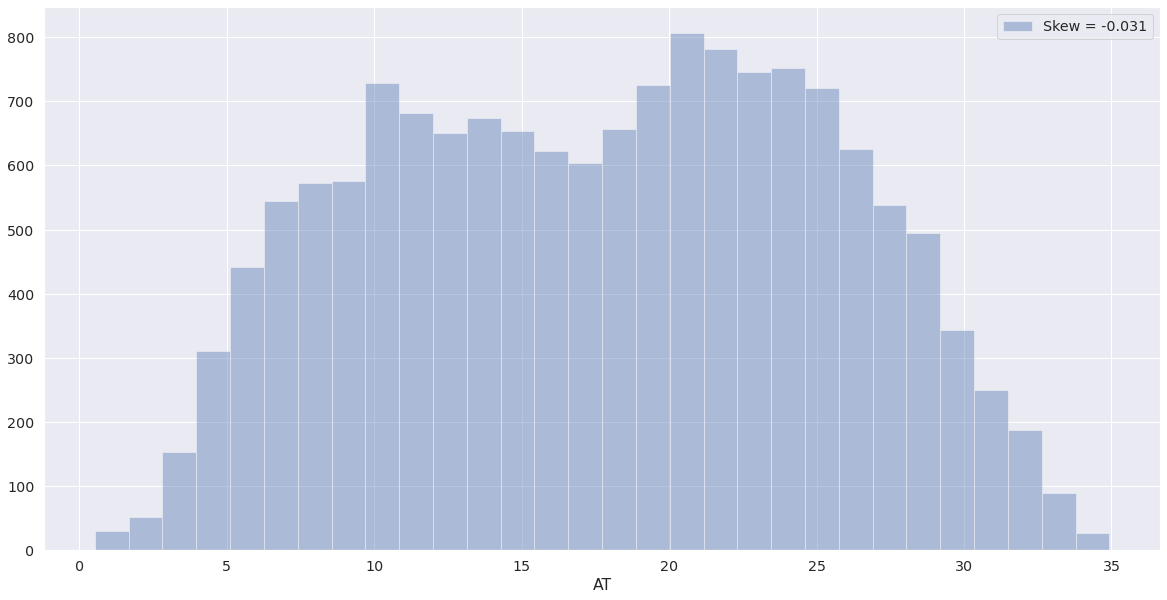

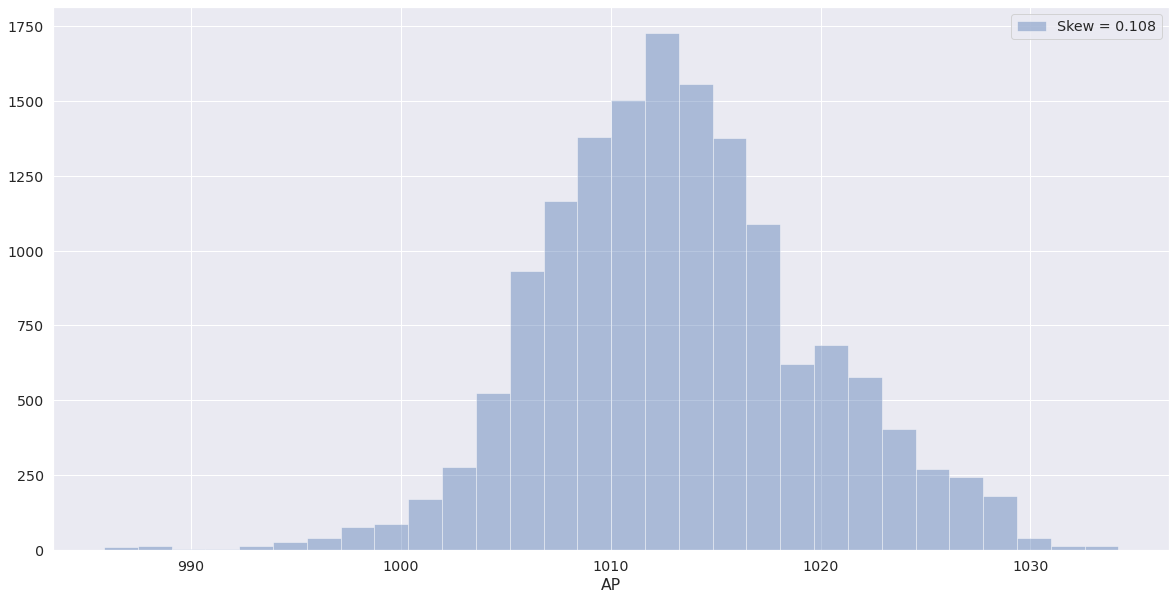

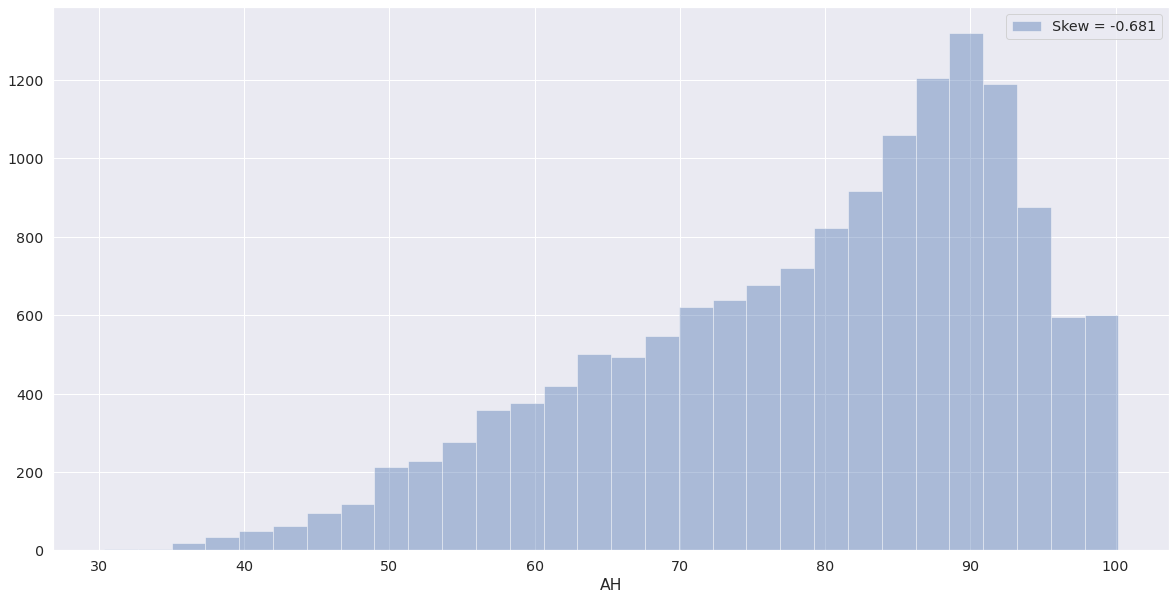

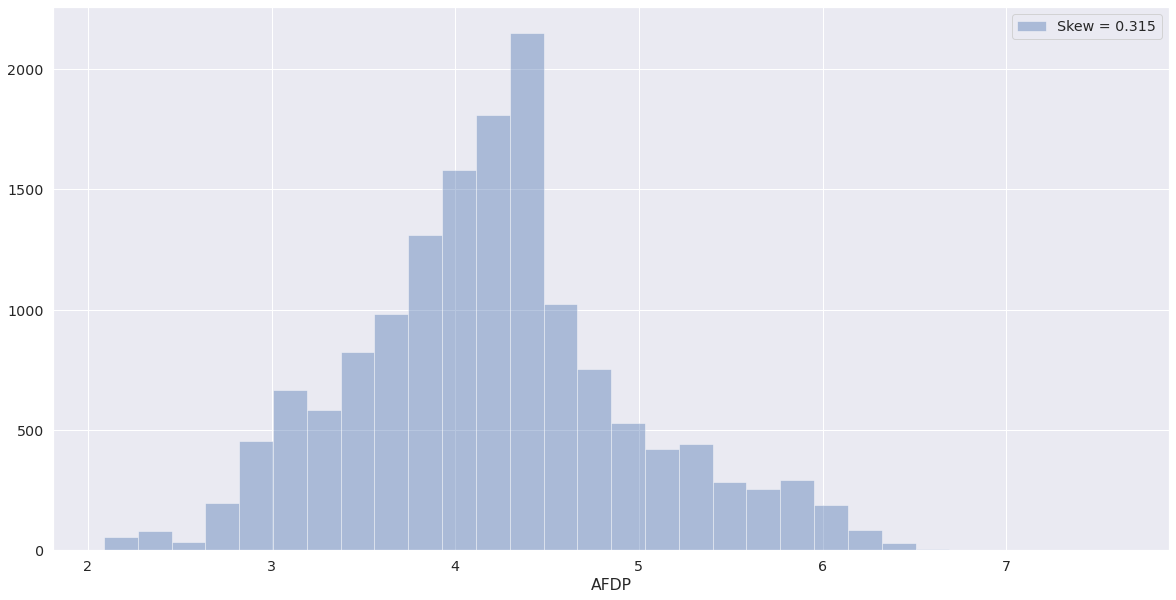

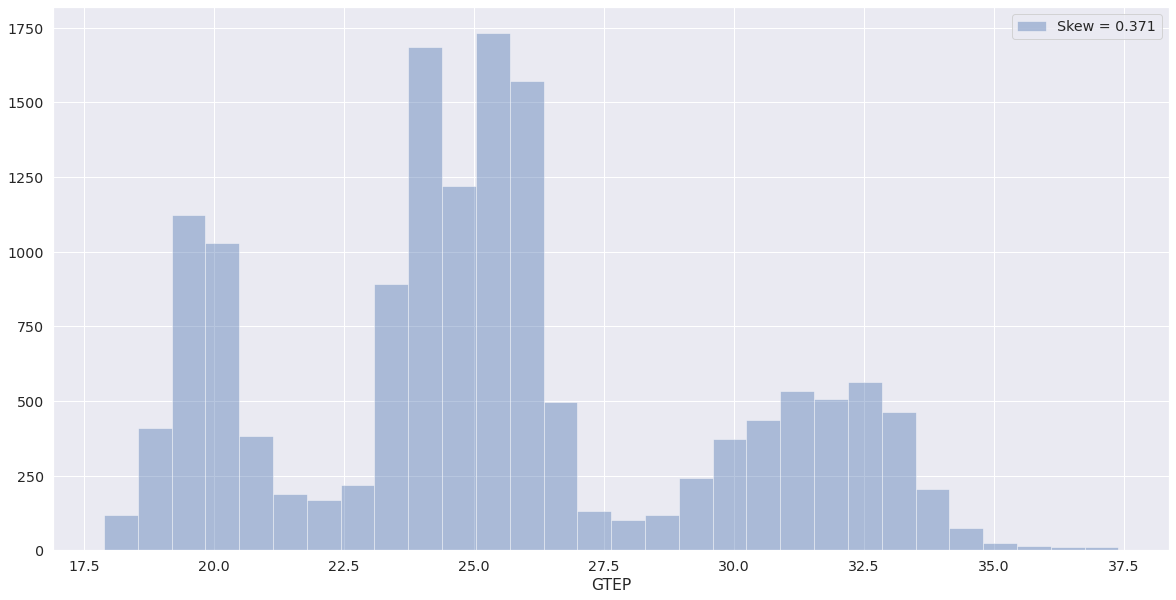

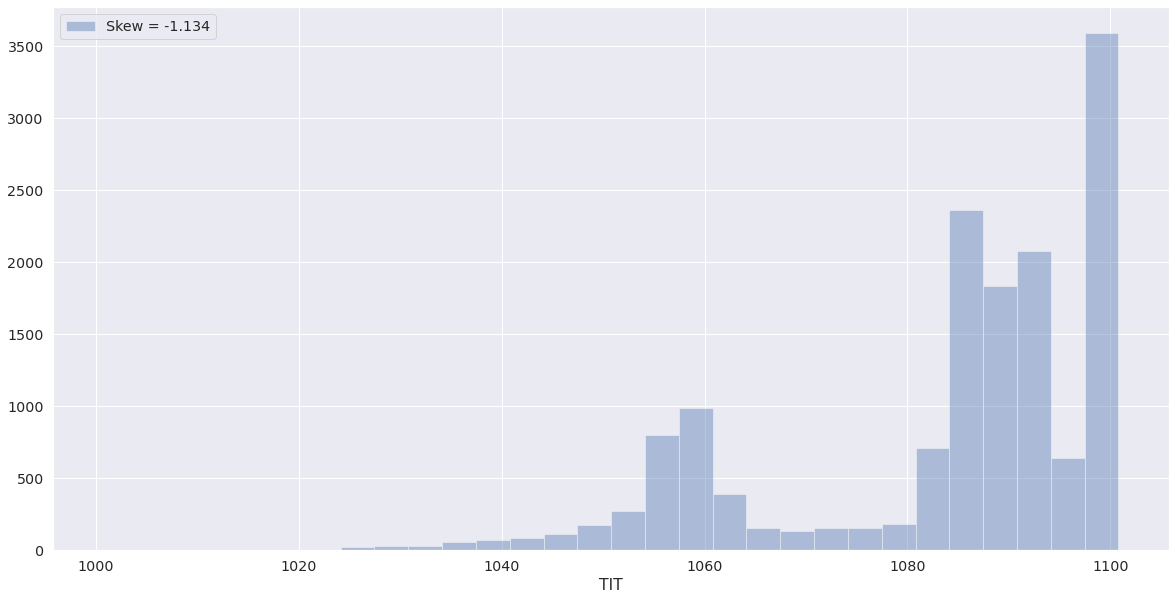

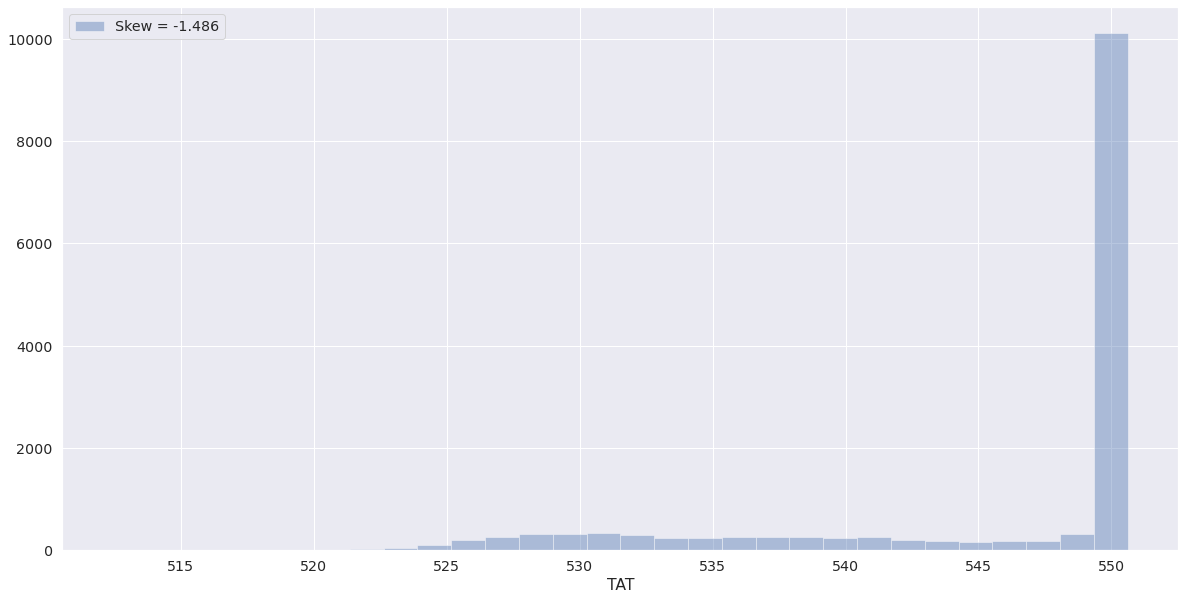

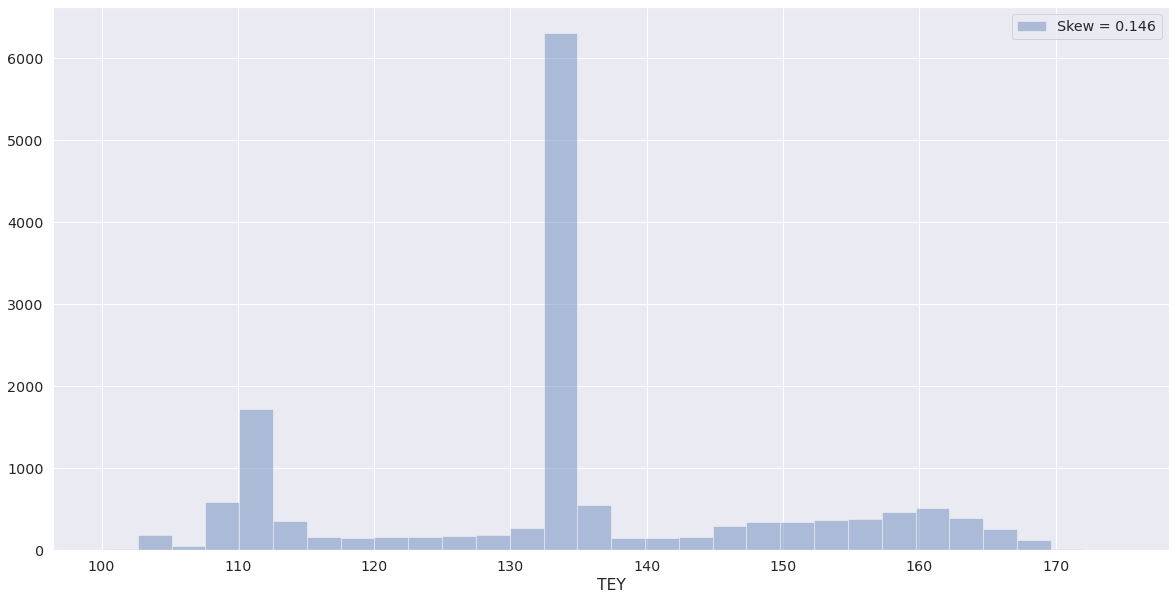

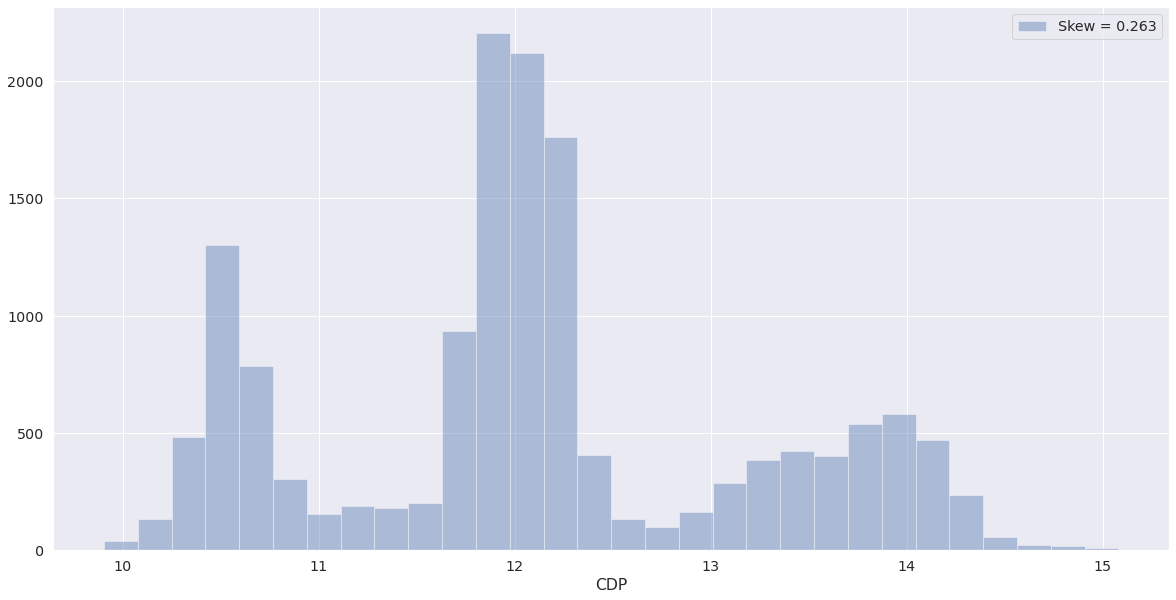

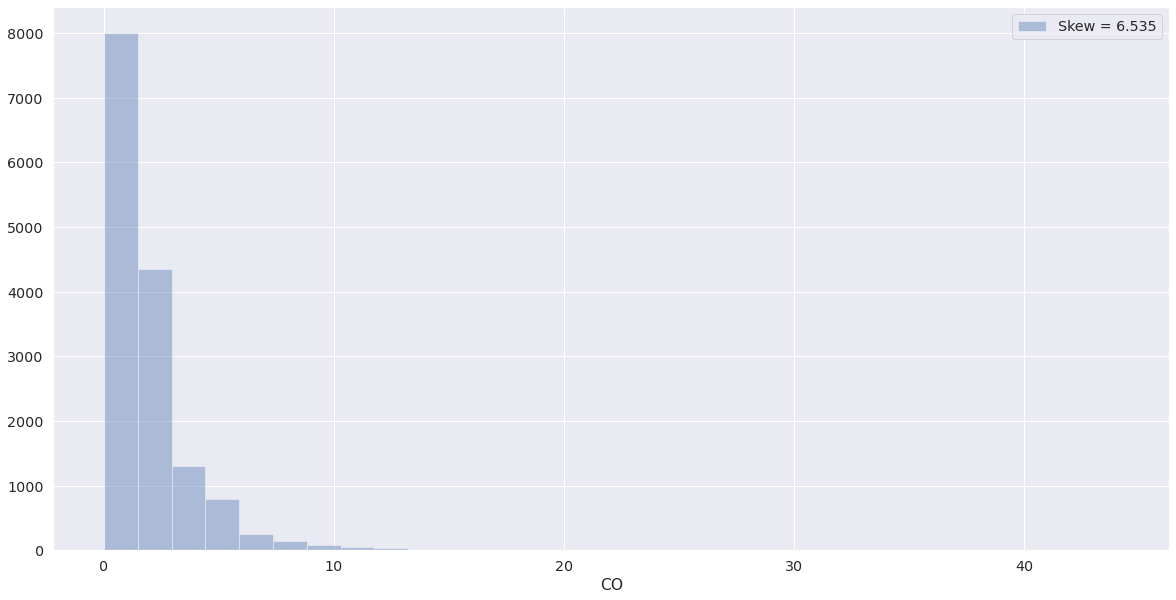

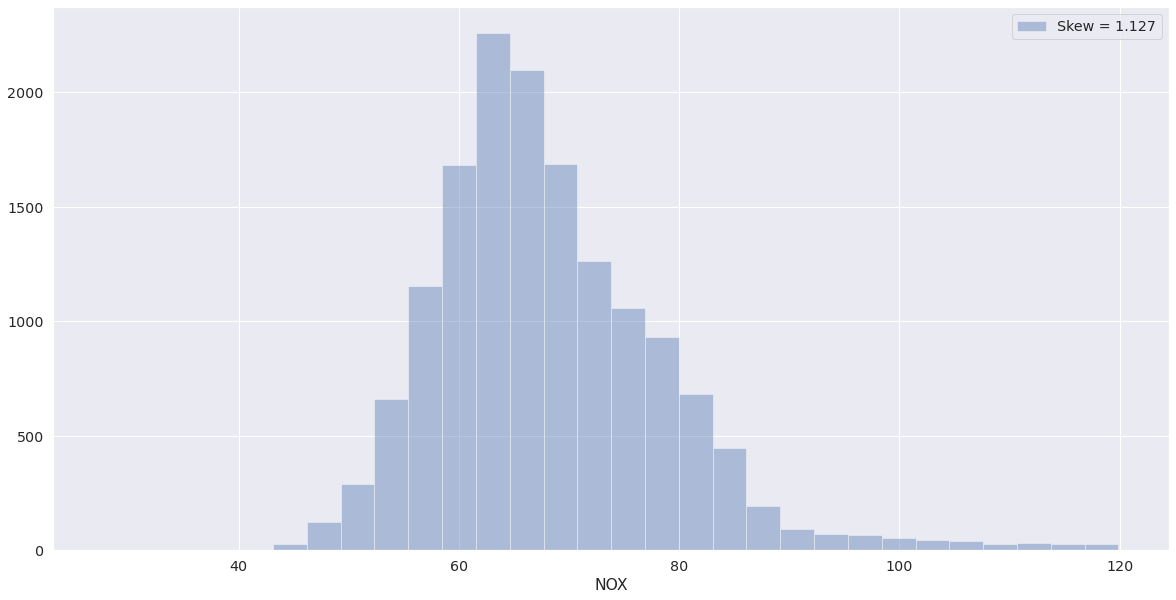

In [ ]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
              
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

        

The dataset contains 1543 observations with more than 2 outliers


In [ ]:
numerical_features

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

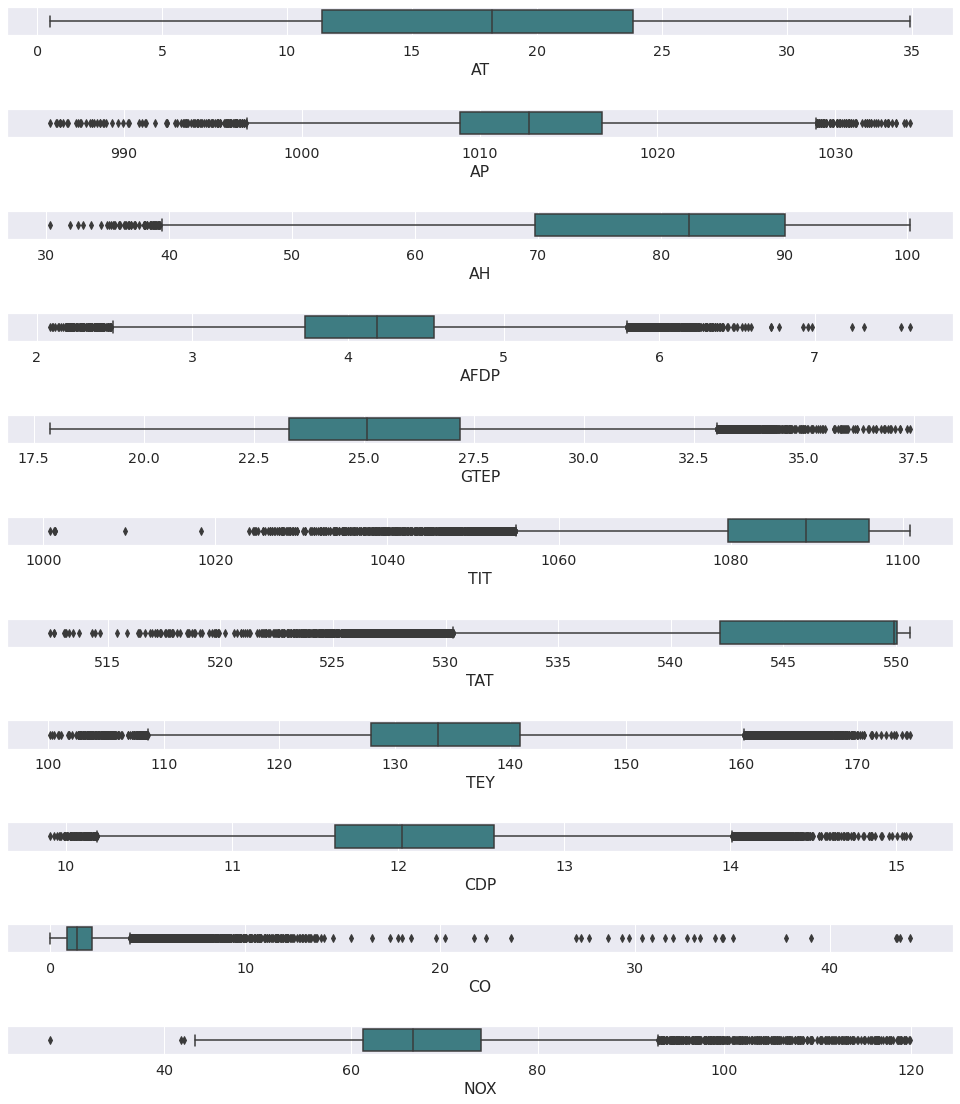

In [ ]:
ot=df.copy() 
fig, axes=plt.subplots(11,1,figsize=(14,16),sharex=False,sharey=False)
sns.boxplot(x='AT',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data=ot,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data=ot,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

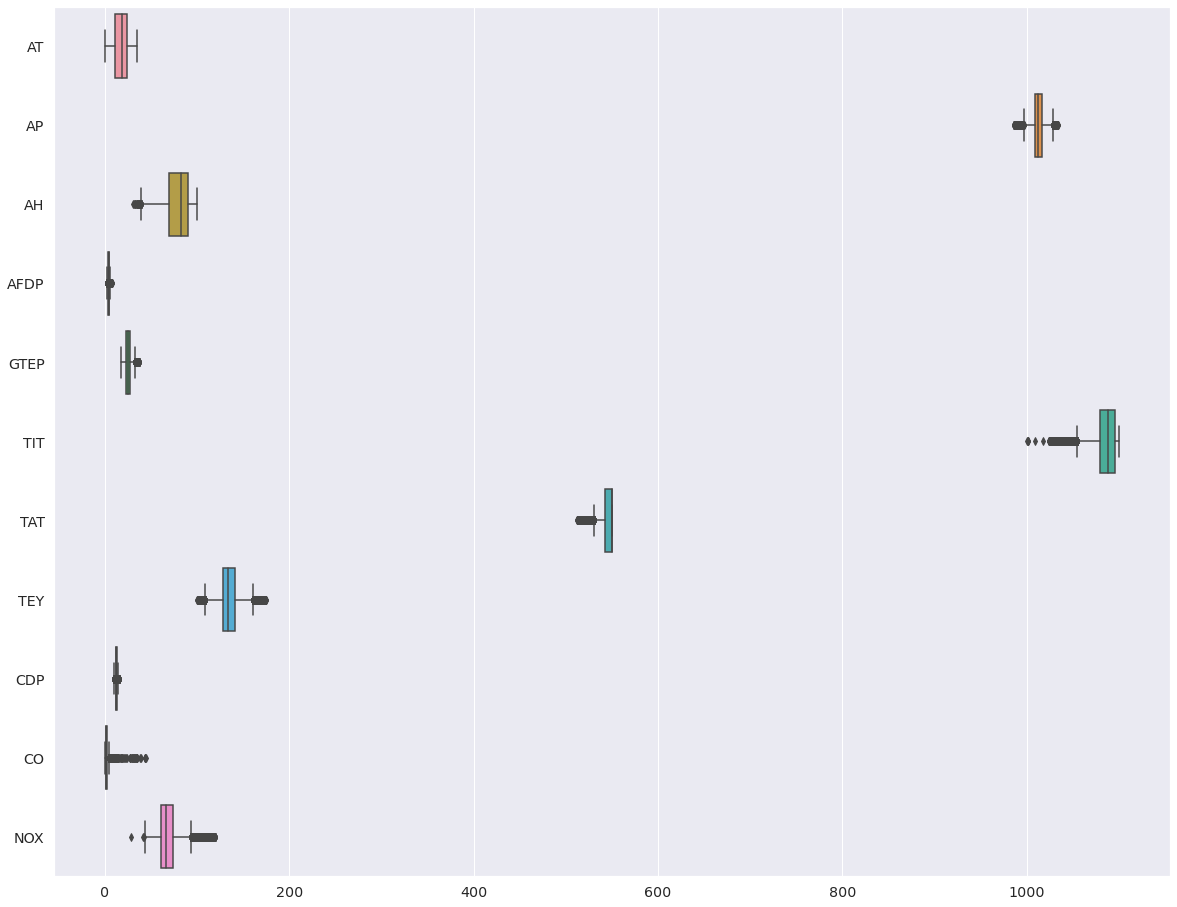

In [ ]:
#outlier
plt.figure(figsize=(20,16))
sns.boxplot(data=df[numerical_features], orient="h")

Text(0.5, 1.0, 'Histogram of the Target Column')

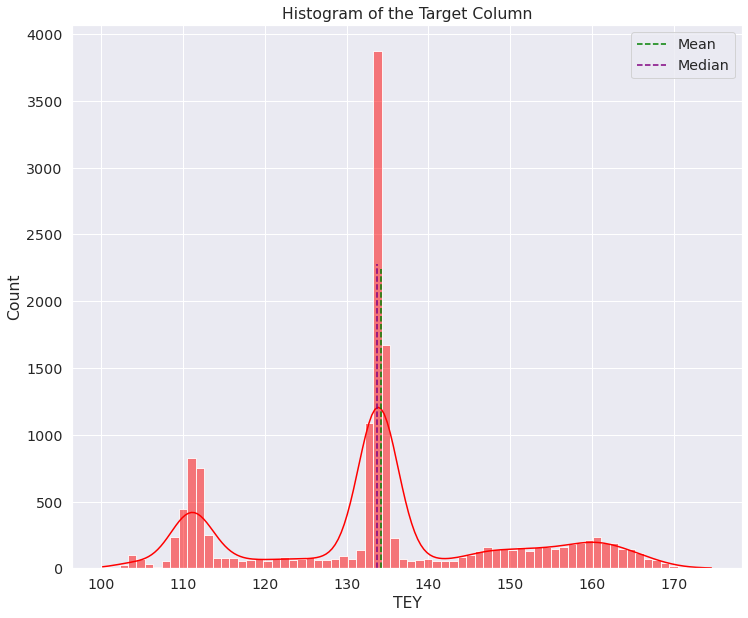

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
sns.histplot(data=df,x="TEY",color="red",kde=True)
plt.axvline(x=df["TEY"].mean(),ymax=0.55,color="green",linestyle='--',label="Mean")
plt.axvline(x=df["TEY"].median(),ymax=0.56,color="purple",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of the Target Column")

Text(0.5, 1.0, 'Cumulative of the Target Column')

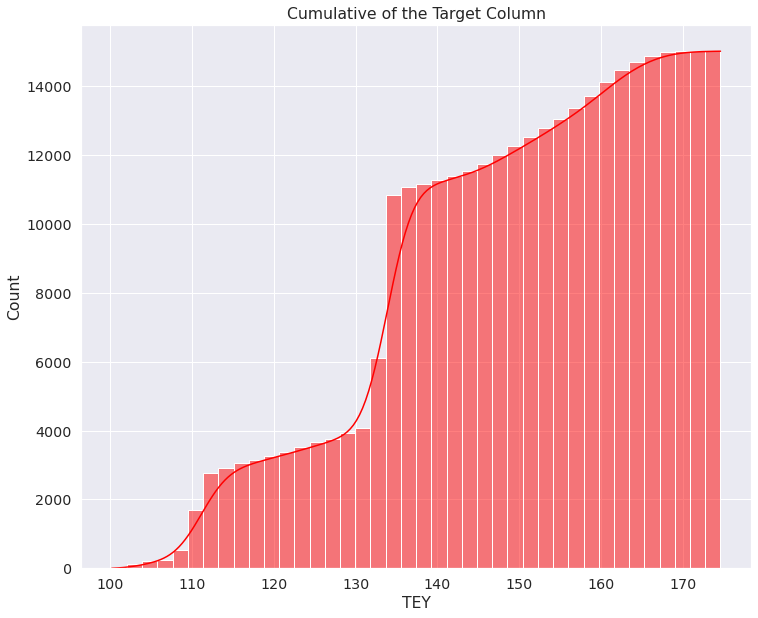

In [ ]:
plt.figure(figsize = (12,10))
sns.histplot(df["TEY"],kde=True,bins=40,color="red",cumulative=True)
plt.title("Cumulative of the Target Column")

Multivariate Analysis

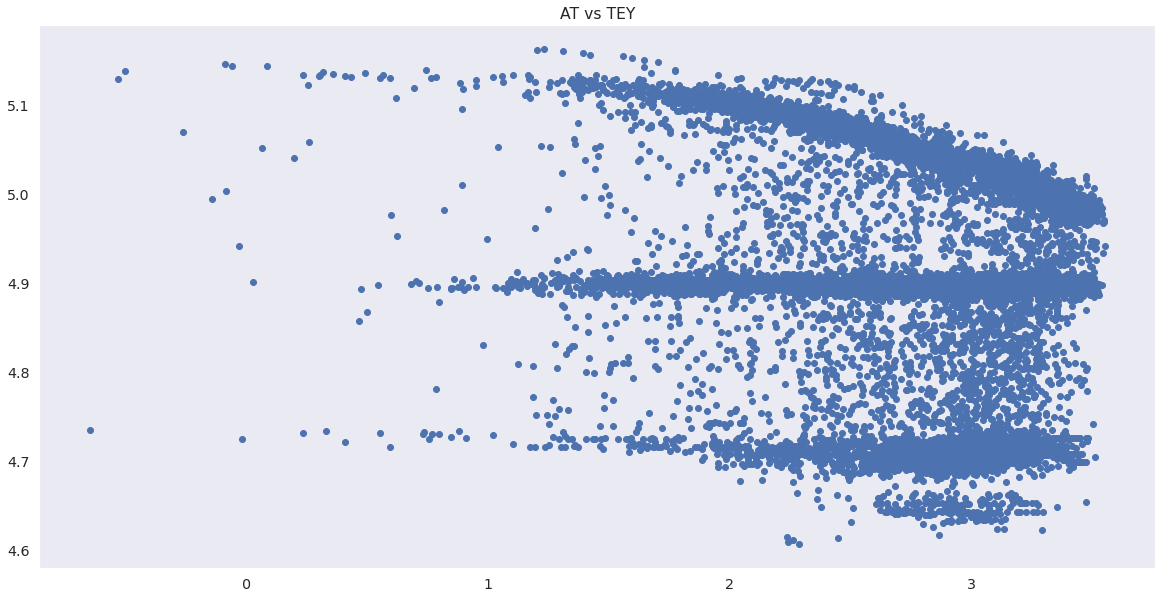

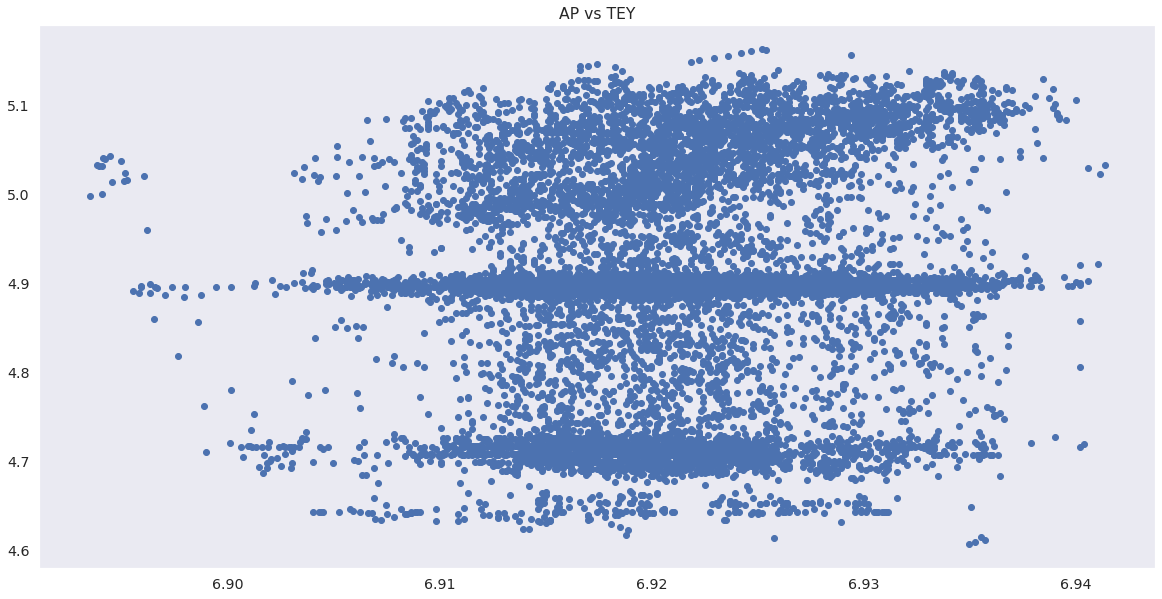

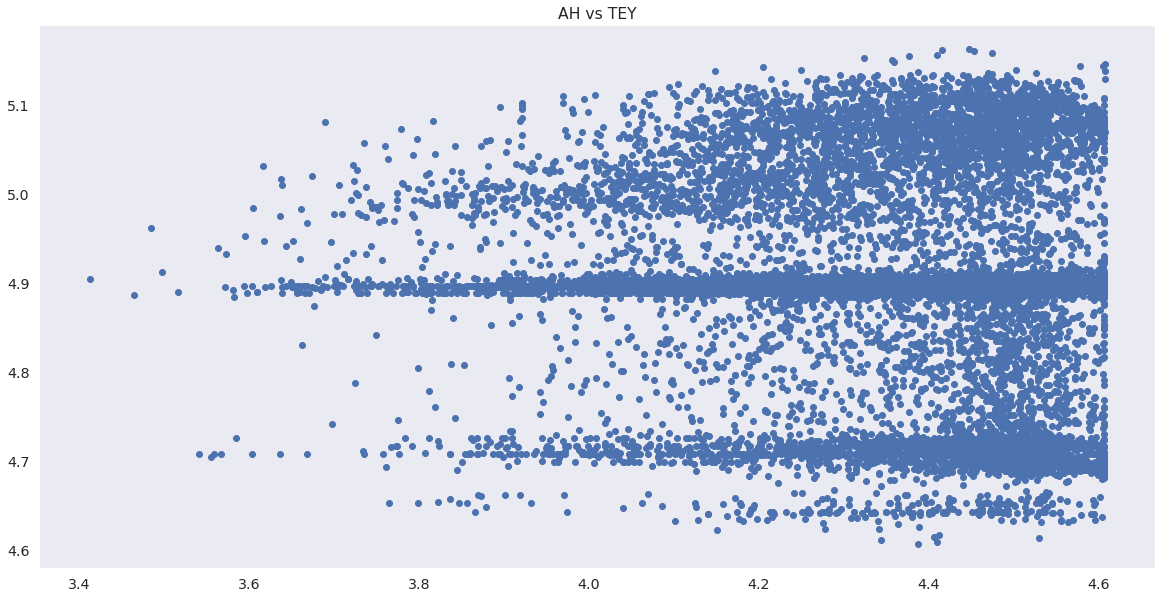

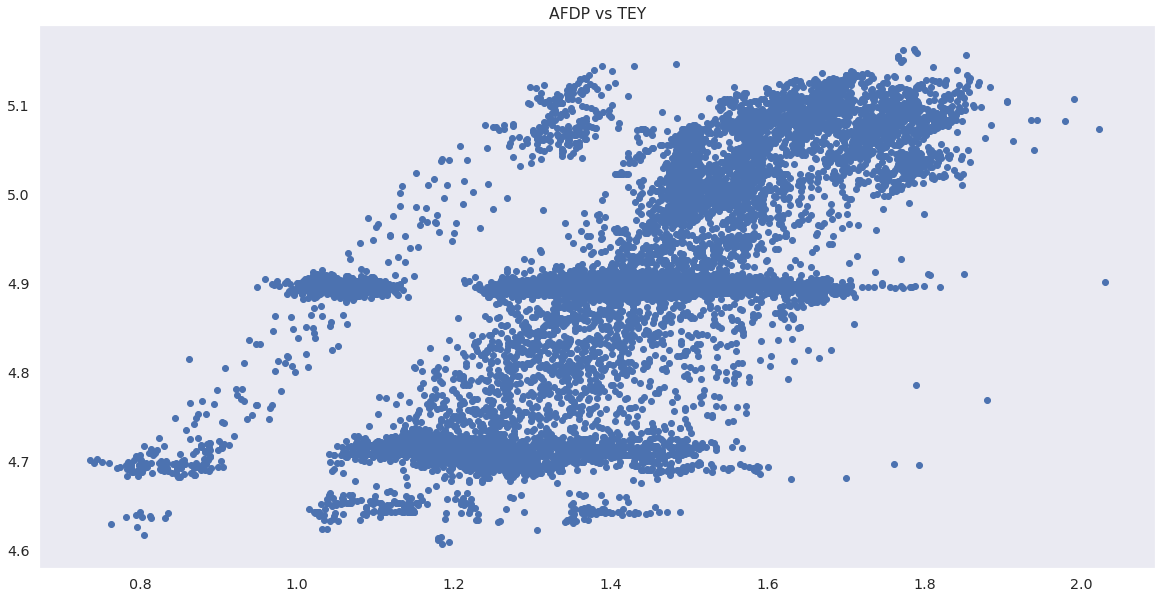

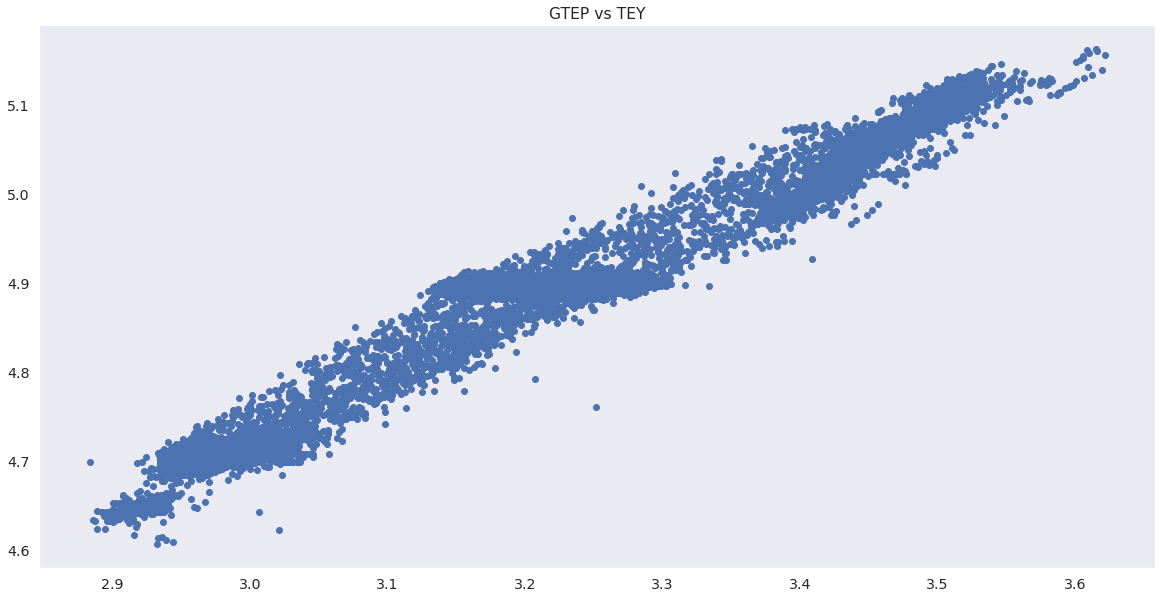

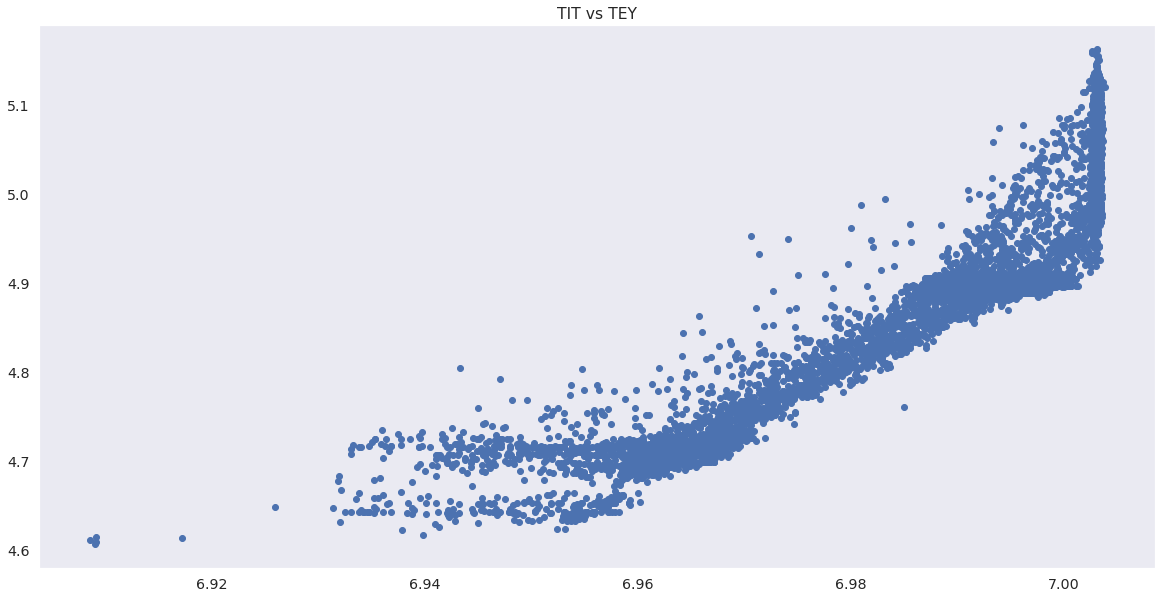

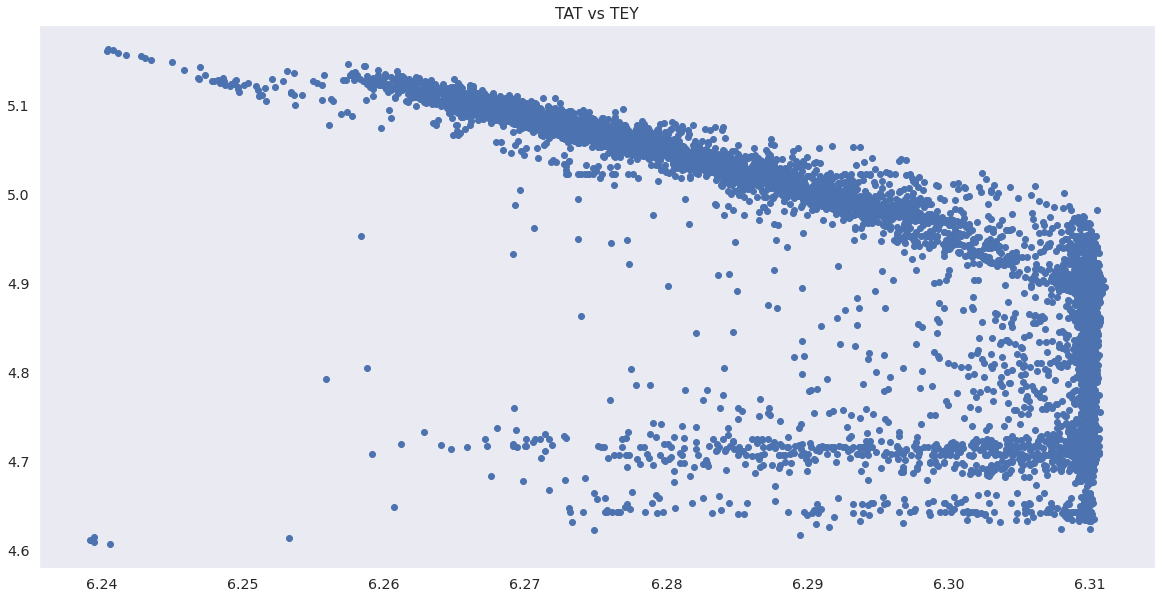

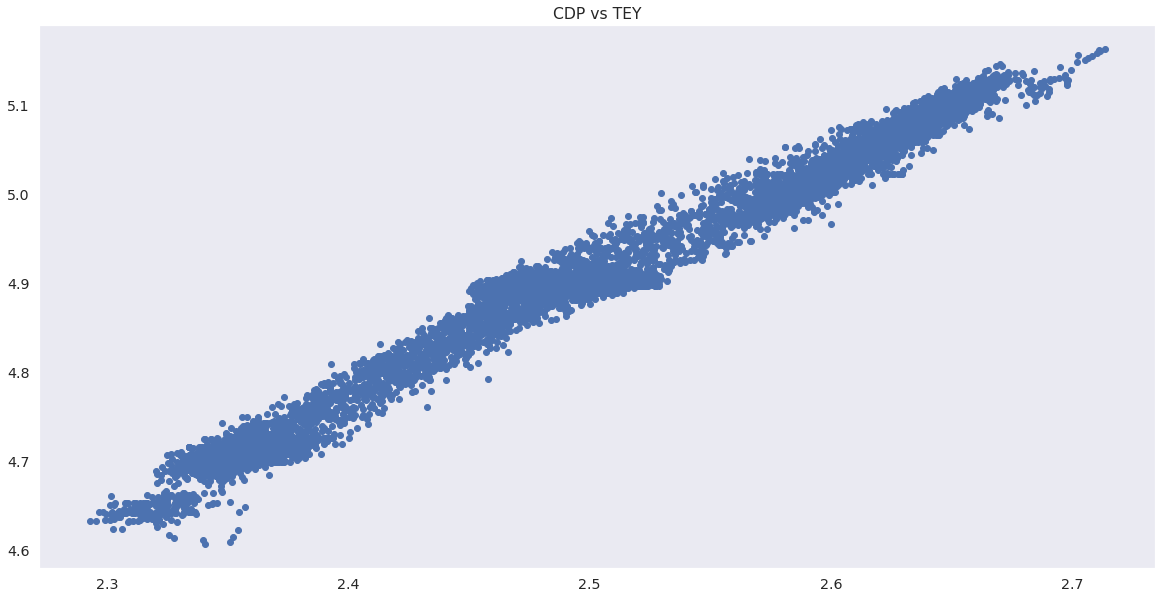

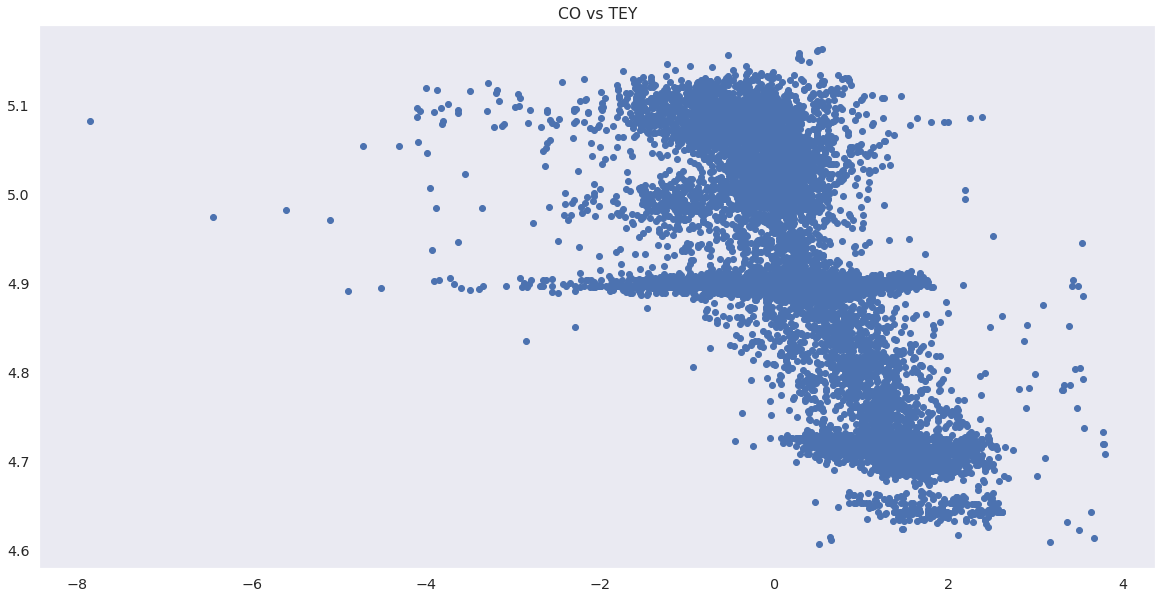

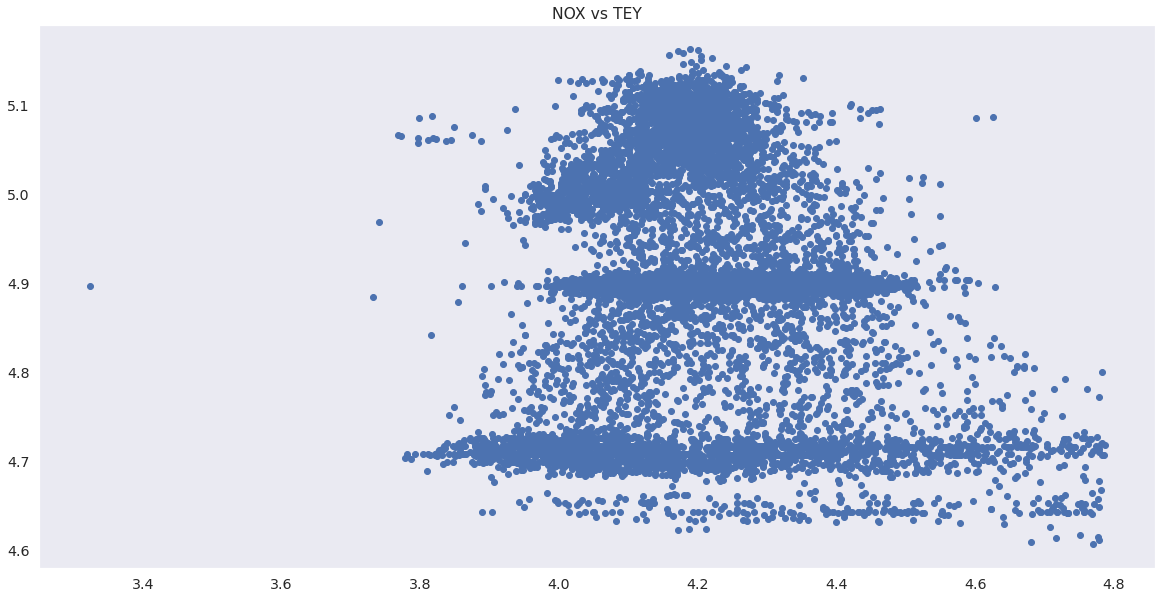

In [ ]:
for i in df.columns:
    if i!="TEY": 
        plt.scatter(np.log(df[i]), np.log(df['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()

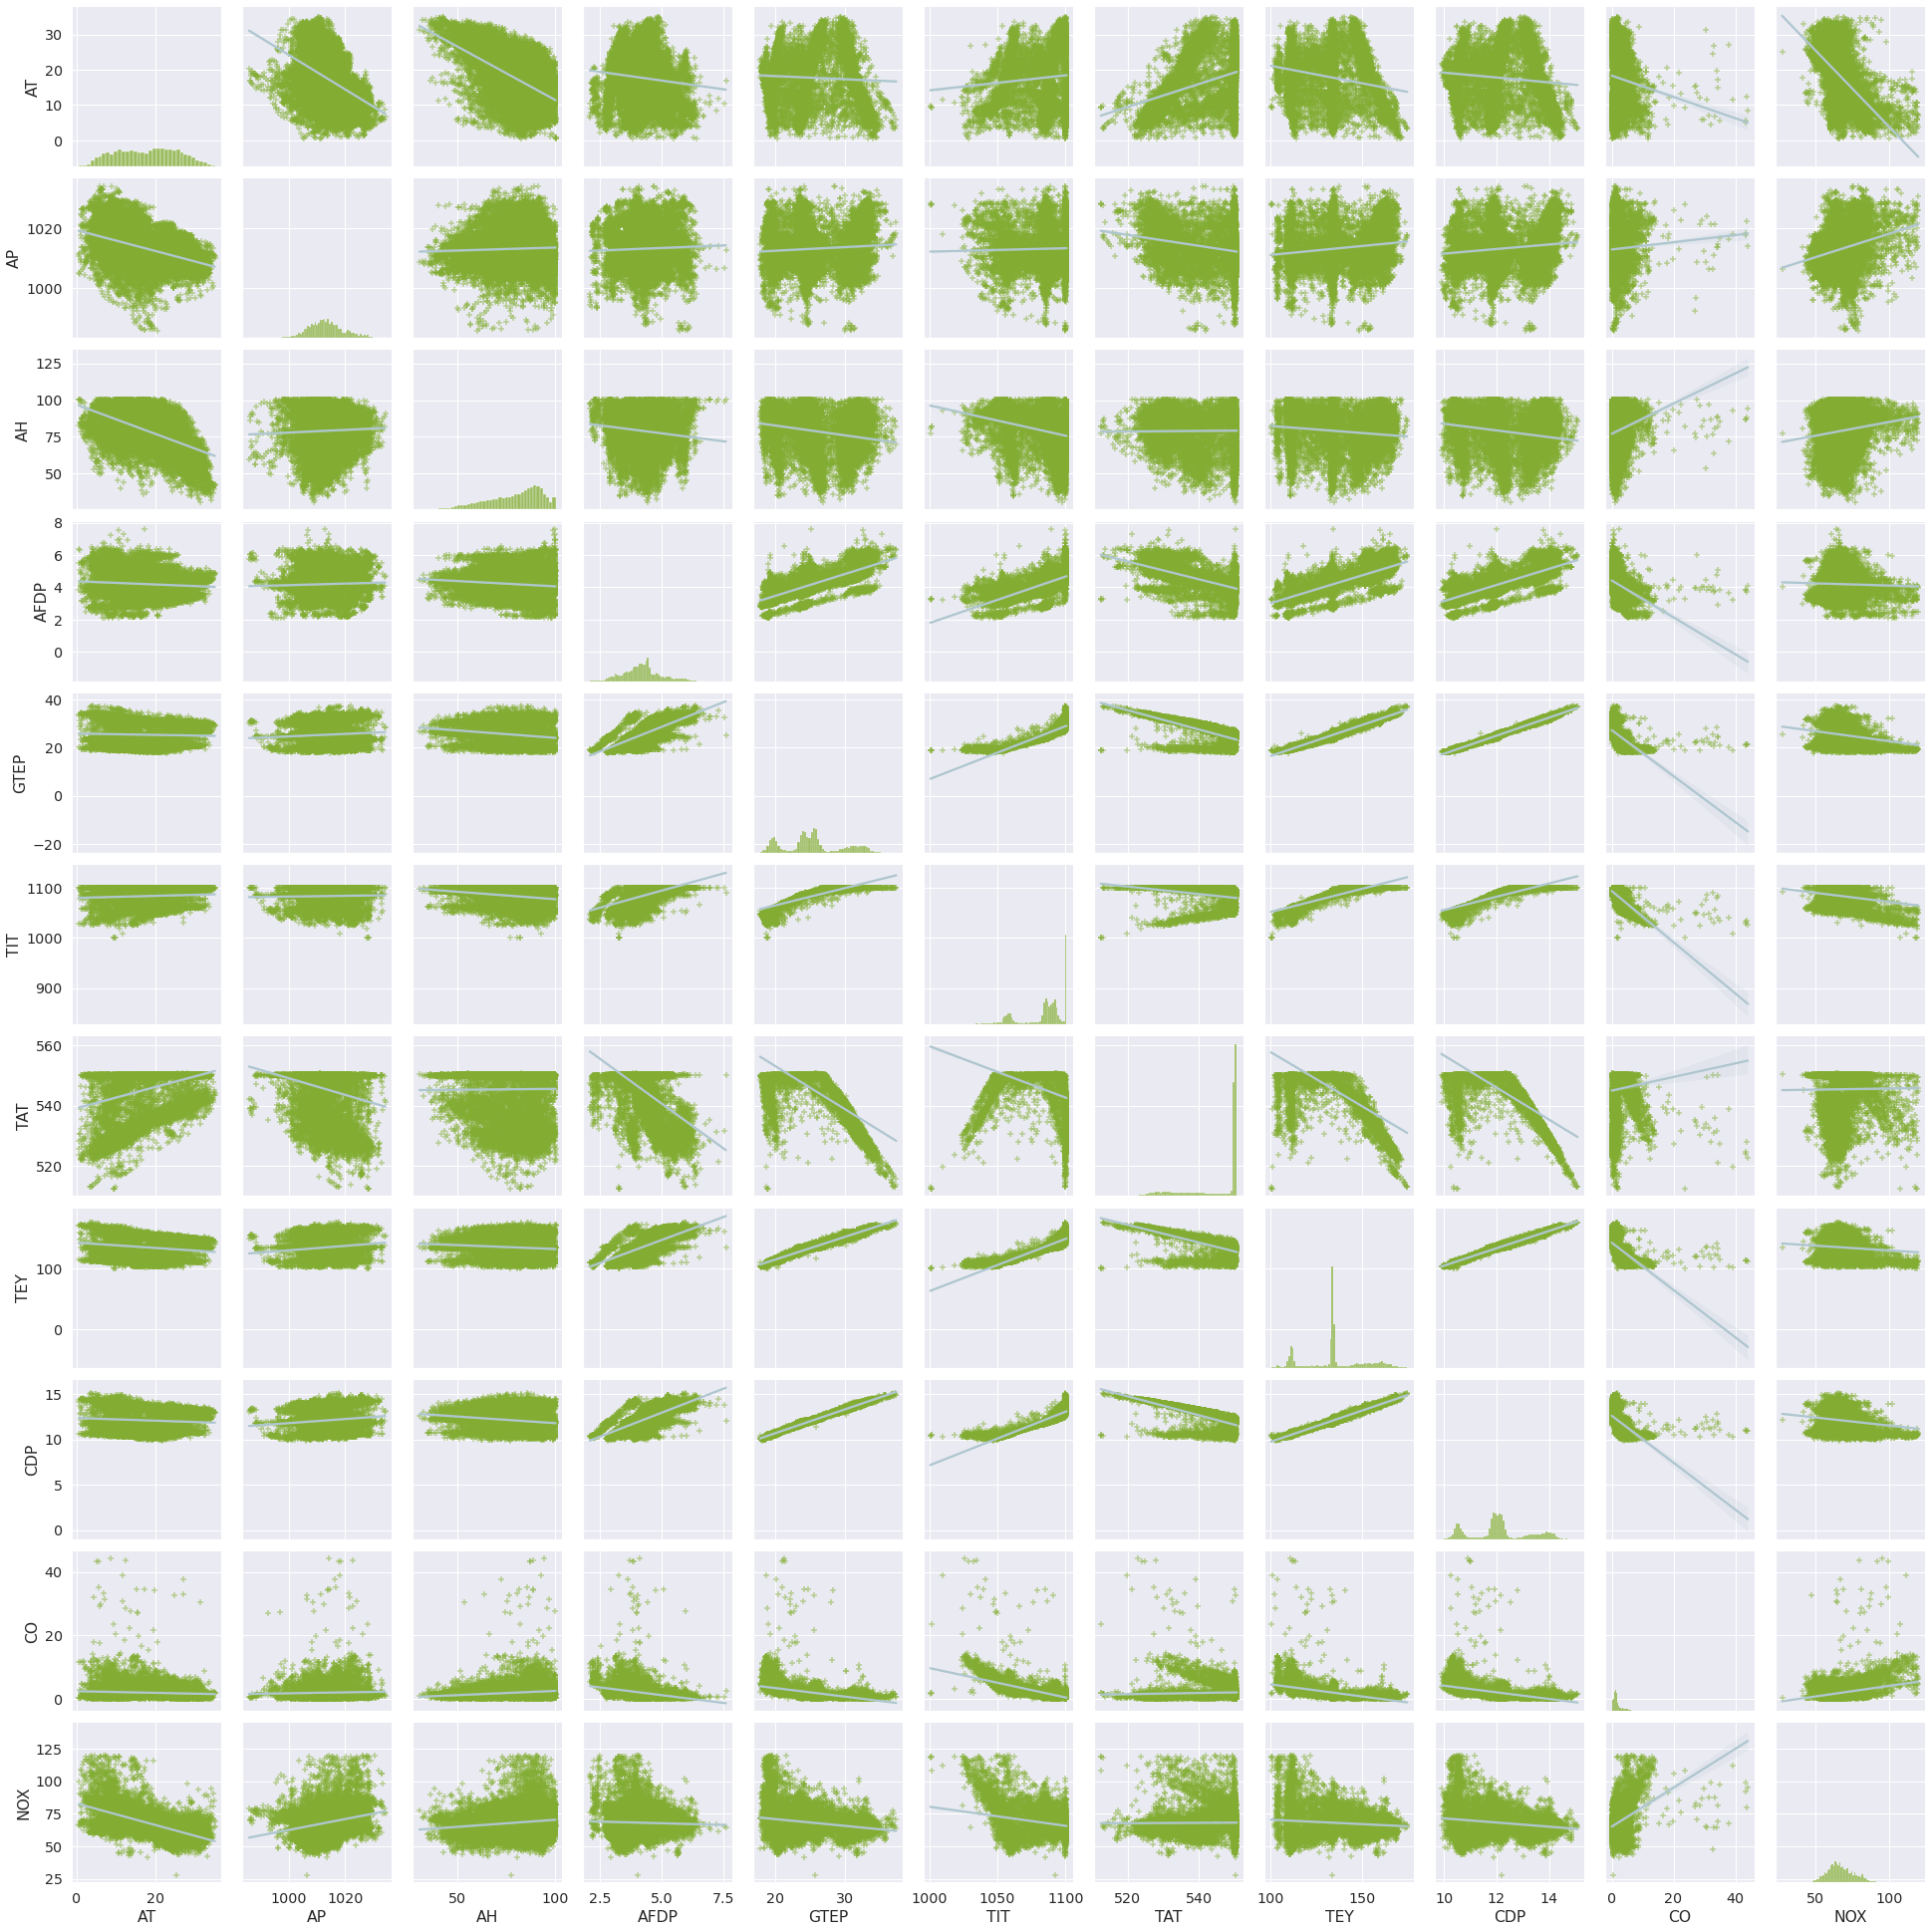

In [ ]:
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="auto",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               
                 diag_kws= {'color': '#82ad32'})

<Figure size 1440x1440 with 0 Axes>

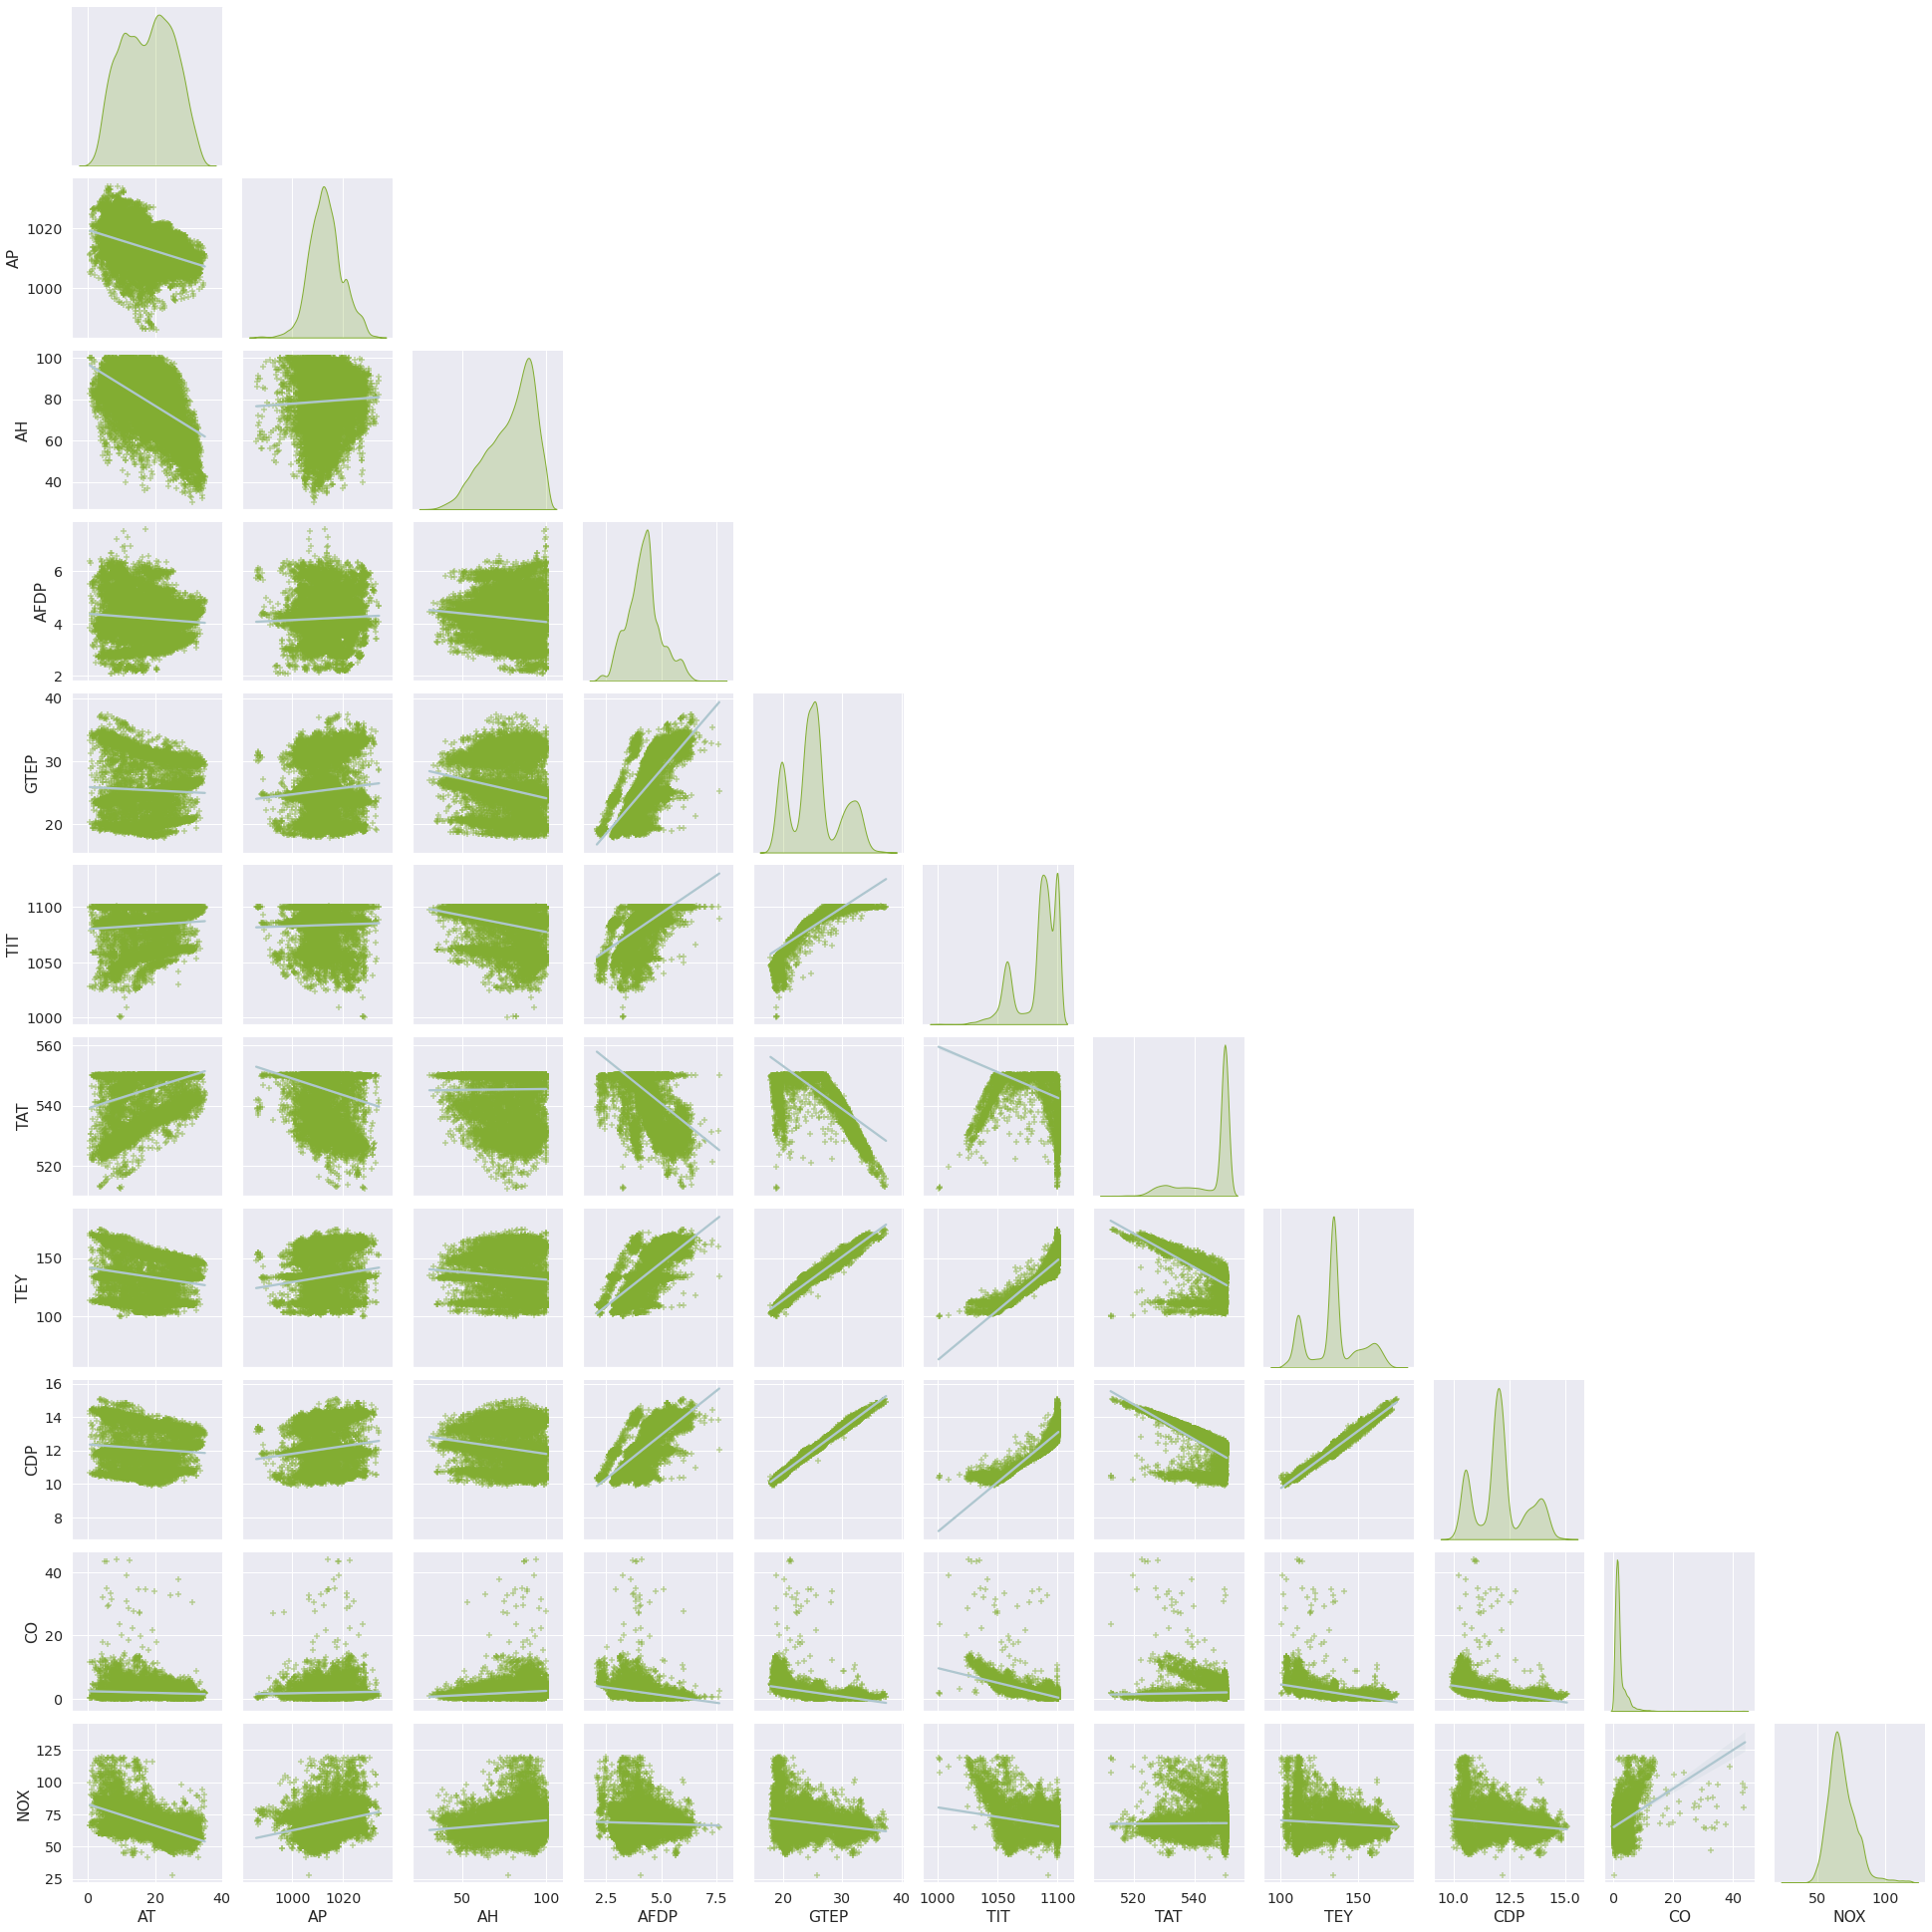

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})

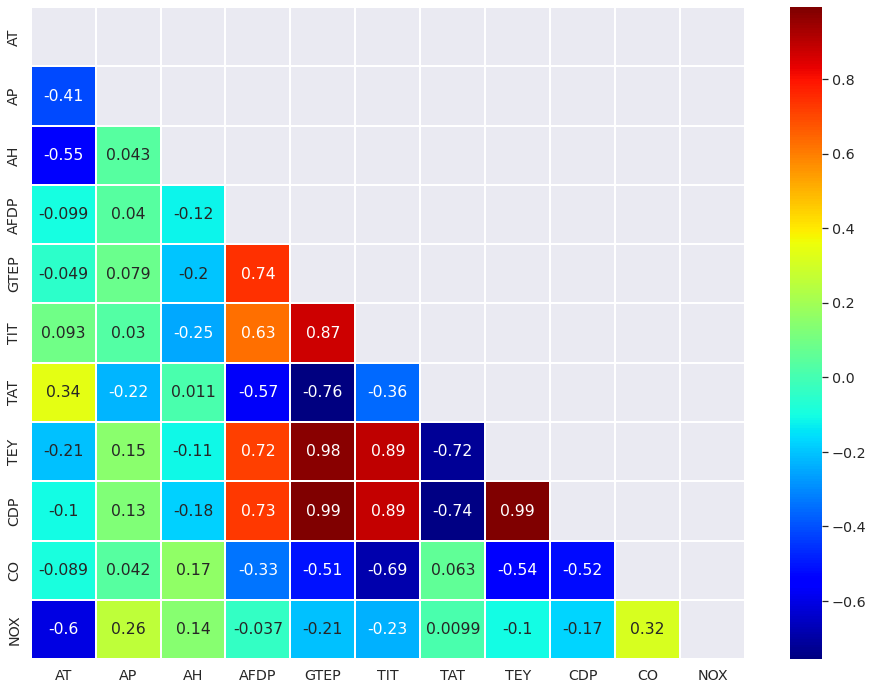

In [ ]:
# Having a look at the correlation matrix

plt.figure(figsize=(16,12))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)


In [ ]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

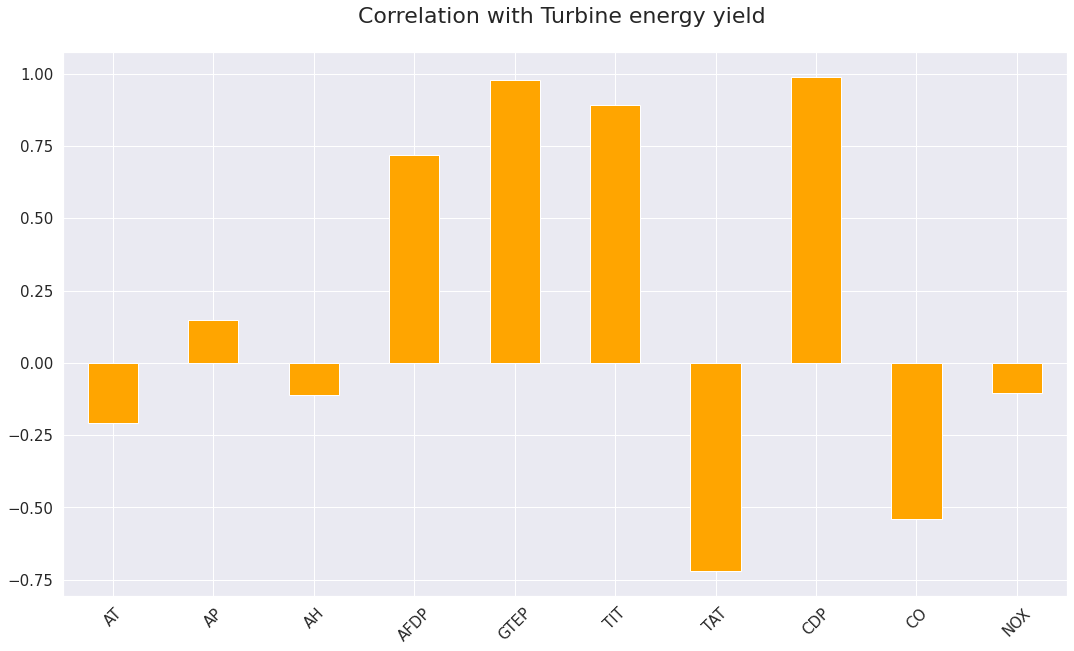

In [ ]:
data2 = df.copy()

correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

Feature Selection Technique

In [ ]:
#Feature importance
from numpy import set_printoptions

In [ ]:
# feature extraction
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

In [ ]:
# summarize scores
scores = fit.scores_

features = fit.transform(x)

In [ ]:
score_df = pd.DataFrame(list(zip(scores, x.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

Score Feature
7  1.714312     CDP
4  1.600303    GTEP
5  1.325092     TIT
6  0.893806     TAT
3  0.660587    AFDP
8  0.513010      CO
0  0.412361      AT
9  0.300797     NOX
1  0.137772      AP
2  0.097506      AH

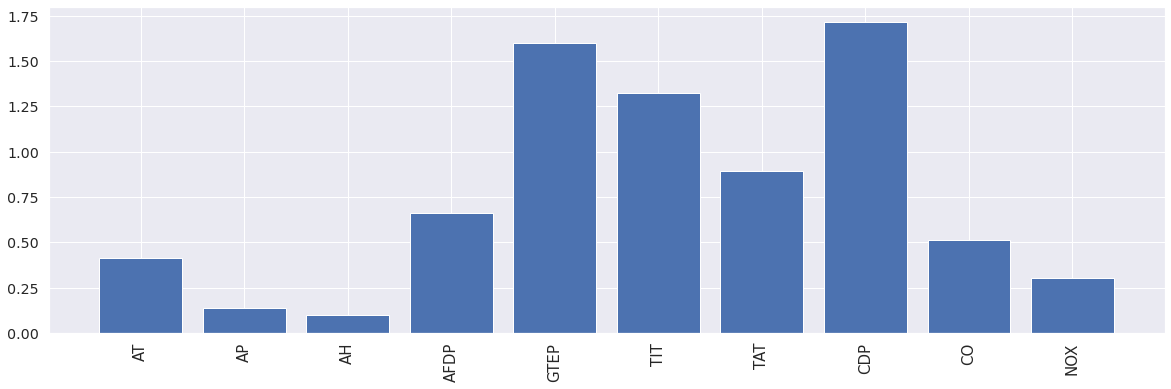

In [ ]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

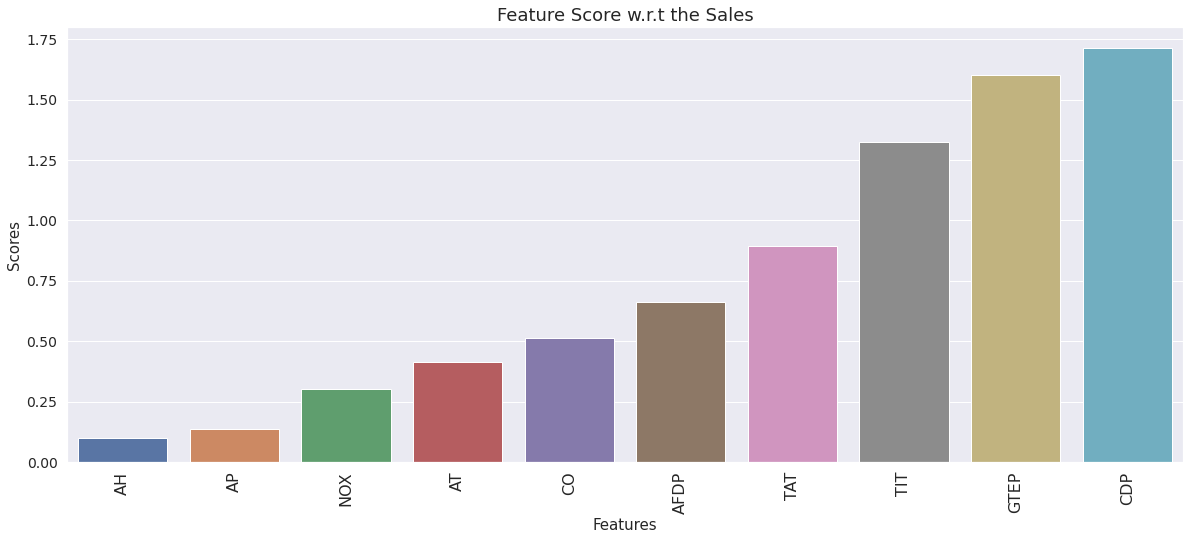

In [ ]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()


In [ ]:
score_df.sort_values('Score',ascending=False)

Score Feature
7  1.714312     CDP
4  1.600303    GTEP
5  1.325092     TIT
6  0.893806     TAT
3  0.660587    AFDP
8  0.513010      CO
0  0.412361      AT
9  0.300797     NOX
1  0.137772      AP
2  0.097506      AH

In [ ]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

CDP    GTEP     TIT     TAT    AFDP      CO      AT     TEY
0  10.605  19.663  1059.2  550.00  3.5000  3.1547  6.8594  114.70
1  10.598  19.728  1059.3  550.00  3.4998  3.2363  6.7850  114.72
2  10.601  19.779  1059.4  549.87  3.4824  3.2012  6.8977  114.71
3  10.606  19.792  1059.6  549.99  3.4805  3.1923  7.0569  114.72
4  10.612  19.765  1059.7  549.98  3.4976  3.2484  7.3978  114.72

Data Pre-Processing

In [ ]:
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))


Continuous Feature Count 8


In [ ]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

CDP      GTEP       TIT       TAT      AFDP        CO        AT  \
0 -1.357331 -1.379101 -1.488376  0.585240 -0.921232  0.532012 -1.439778   
1 -1.363676 -1.363528 -1.482325  0.585240 -0.921495  0.568733 -1.449601   
2 -1.360957 -1.351309 -1.476275  0.568715 -0.944385  0.552938 -1.434721   
3 -1.356424 -1.348194 -1.464173  0.583969 -0.946884  0.548933 -1.413702   
4 -1.350985 -1.354663 -1.458123  0.582698 -0.924389  0.574179 -1.368693   

        TEY  
0 -1.231172  
1 -1.229909  
2 -1.230541  
3 -1.229909  
4 -1.229909

In [ ]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Devaition','\n',np.round(df_standard_scaled.std()),1)


Mean
 CDP     0.0
GTEP   -0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT      0.0
TEY     0.0
dtype: float64 
Standard Devaition 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64 1


Model Building Neural Networks


In [ ]:
model_data

CDP    GTEP     TIT     TAT    AFDP      CO      AT     TEY
0      10.605  19.663  1059.2  550.00  3.5000  3.1547  6.8594  114.70
1      10.598  19.728  1059.3  550.00  3.4998  3.2363  6.7850  114.72
2      10.601  19.779  1059.4  549.87  3.4824  3.2012  6.8977  114.71
3      10.606  19.792  1059.6  549.99  3.4805  3.1923  7.0569  114.72
4      10.612  19.765  1059.7  549.98  3.4976  3.2484  7.3978  114.72
...       ...     ...     ...     ...     ...     ...     ...     ...
15034  10.400  19.164  1049.7  546.21  3.5421  4.5186  9.0301  111.61
15035  10.433  19.414  1046.3  543.22  3.5059  4.8470  7.8879  111.78
15036  10.483  19.530  1037.7  537.32  3.4770  7.9632  7.2647  110.19
15037  10.533  19.377  1043.2  541.24  3.4486  6.2494  7.0060  110.74
15038  10.583  19.306  1049.9  545.85  3.4275  4.9816  6.9279  111.58

[15039 rows x 8 columns]

In [ ]:
#assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

#for removing heading from y_test
#y_test = y_test.values

(12031, 7)
(3008, 7)
(12031, 1)
(3008, 1)


In [ ]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 7)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)


Epoch 1/100
169/169 [==============================] - 1s 4ms/step - loss: 17633.8047 - mae: 131.8322 - mse: 17633.8047 - val_loss: 16810.7012 - val_mae: 128.6961 - val_mse: 16810.7012
Epoch 2/100
169/169 [==============================] - 1s 3ms/step - loss: 16320.5508 - mae: 126.7568 - mse: 16320.5508 - val_loss: 15767.4922 - val_mae: 124.5772 - val_mse: 15767.4922
Epoch 3/100
169/169 [==============================] - 0s 3ms/step - loss: 15350.6699 - mae: 122.8730 - mse: 15350.6699 - val_loss: 14852.2275 - val_mae: 120.8480 - val_mse: 14852.2275
Epoch 4/100
169/169 [==============================] - 0s 3ms/step - loss: 14468.0342 - mae: 119.2272 - mse: 14468.0342 - val_loss: 14001.0518 - val_mae: 117.2735 - val_mse: 14001.0518
Epoch 5/100
169/169 [==============================] - 0s 3ms/step - loss: 13639.8506 - mae: 115.7034 - mse: 13639.8506 - val_loss: 13196.9189 - val_mae: 113.7934 - val_mse: 13196.9189
Epoch 6/100
169/169 [==============================] - 0s 3ms/step - loss: 

In [ ]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size=20 , epochs = 100, verbose=0)


Predicting values from Model using same dataset

In [ ]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 2ms/step
(3008, 9)


CDP    GTEP     TIT     TAT    AFDP        CO       AT  Actual  \
13312  12.219  25.762  1092.5  550.25  4.0023   1.26430  24.0930  134.46   
12627  10.791  20.085  1059.6  549.94  3.2106   2.69370  20.4500  111.88   
6393   12.126  25.221  1089.9  549.62  4.5325   1.96250  20.2620  133.72   
4990   12.218  25.965  1092.9  549.96  4.4266   1.57120  26.8620  133.79   
12462  10.466  19.688  1056.9  550.01  3.1241   2.29960  19.4090  110.77   
7405   10.624  19.387  1058.9  550.17  3.3709   4.27640   2.2158  113.32   
10993  12.088  25.392  1089.7  550.11  3.7871   0.83578  23.8520  133.77   
9488   11.498  23.225  1079.4  549.60  4.2837   2.01980  12.3950  128.98   
14201  13.971  32.518  1100.1  528.98  5.1559   0.87760  12.3590  159.42   
9757   13.862  32.105  1100.0  530.69  5.9309  10.75000   8.6376  161.86   

        Predicted  
13312  134.607025  
12627  112.621422  
6393   134.089935  
4990   133.999161  
12462  111.432922  
7405   113.897743  
10993  133.783798  
9488   129.233200  
14201  160.459564  
9757   159.750458

In [ ]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis =1 , inplace = True)


In [ ]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %']=APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  99.63754357007478


Actual   Predicted     APE %
13312  134.46  134.607025  0.109345
12627  111.88  112.621422  0.662694
6393   133.72  134.089935  0.276649
4990   133.79  133.999161  0.156335
12462  110.77  111.432922  0.598467

In [ ]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

Actual   Predicted     APE %     Error
0     134.46  134.607025  0.109345 -0.001093
1     111.88  112.621422  0.662694 -0.006627
2     133.72  134.089935  0.276649 -0.002766
3     133.79  133.999161  0.156335 -0.001563
4     110.77  111.432922  0.598467 -0.005985
...      ...         ...       ...       ...
3003  119.25  120.071770  0.689115 -0.006891
3004  133.74  134.039688  0.224083 -0.002241
3005  146.31  146.720154  0.280332 -0.002803
3006  150.07  149.744431  0.216945  0.002169
3007  111.77  111.599220  0.152796  0.001528

[3008 rows x 4 columns]

Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

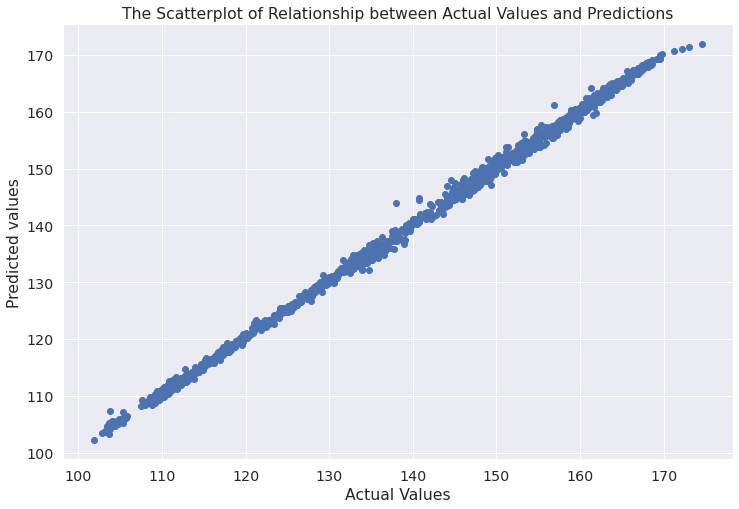

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [ ]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE: 0.4790007686614992
MSE: 0.41435291752107406
RMSE: 0.6437025070023218


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))


376/376 [==============================] - 1s 2ms/step
R2_score (train):  0.9987605721190344
R2_score (test):  0.9983451673384425


In [ ]:
#Evaluation of  the explained variance score (R^2)
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 


This shows our model predict % 99.87 of the target correctly


Residual Analysis

Test for Normality of Residuals (Q-Q Plot)

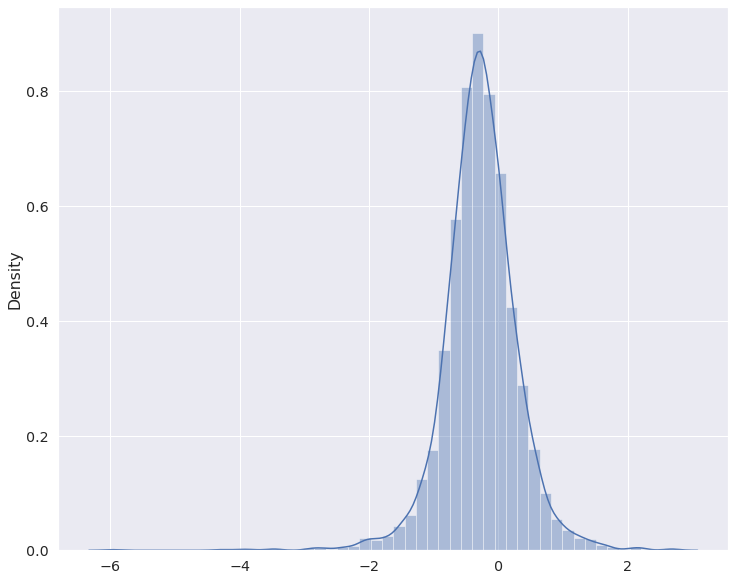

In [ ]:

plt.figure(figsize=(12,10))
sns.distplot(y_test-y_predict_test,bins=50) 


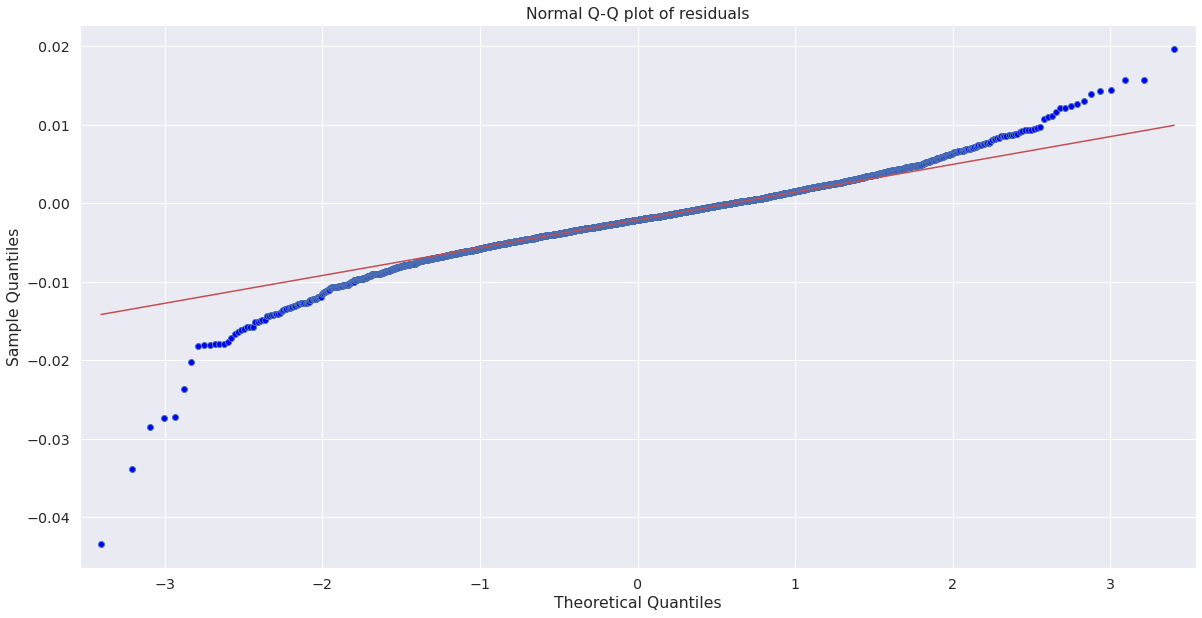

In [ ]:
#Residuals values  = y - yhat
import statsmodels.api as smf
smf.qqplot(predictions_df['Error'], line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()